In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
import pingouin as pg
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

In [55]:
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_prod_0_consolidated.parquet"
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_binsize_0.5_sec_0/"
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_vis_target_0/"
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_aud_target_0/"
results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_keep_units_consistent_0/"

#testing different decoding strategy - context appropriate for response
# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_vis_approriate_response_20250623_204316/" #0.2 sec
# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_vis_approriate_response_20250623_205509/" #0.5 sec
# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_vis_approriate_response_20250623_215643/" #1.5 sec
# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_vis_approriate_response_hits_incl_20250623_221242/" #1.5 sec hits incl

# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/rewarded_modality_1.5sec_0/" #1.5 sec - typical context decoding
# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/context_appropriate_response_1.5sec_0/" #1.5 sec - context appropriate response

# results_path = "s3://aind-scratch-data/dynamic-routing/decoding/results/test_set_crossval_random_state_1/"

#try nonlinear decoders
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/test_nonlinearSVC_multi_timebin_0/"
# results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/test_RandomForest_multi_timebin_0/"



In [56]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [ ]:
# session_table.to_pandas().query('session_id == "664851_2023-11-13"')['areas_recorded'].values

In [ ]:
session_table['project']

In [ ]:
# results=pl.scan_parquet(results_path)

In [ ]:
# results.columns

In [57]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [58]:
# session-wise average decoding accuracy
structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

#add total n units, cross-modal dprime, n good blocks?

new_results_session_df = (
    pl.scan_parquet(results_path)
    .filter(
        pl.col('session_id').is_in(dr_session_list),
    )
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),
    )
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials').not_(),
    )
    #get total n units
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    #join on session table to get cross-modal dprime, etc.
    .join(
        other=session_table.filter(
            pl.col('session_id').is_in(dr_session_list)
        ).select(
            'session_id',
            'n_passing_blocks',
            'cross_modality_dprime_vis_blocks',
            'cross_modality_dprime_aud_blocks',
        ).lazy(),
        on='session_id',
        how='left',
    )
    # get the means for each recording over repeats:
    .group_by(grouping_cols | {'shift_idx', 'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                               'cross_modality_dprime_aud_blocks', 'total_n_units'}, maintain_order=True)
    .agg(
        pl.col('balanced_accuracy_test').mean(), # over repeats
    )
    # get the aligned result and median over shifts:
    .group_by(grouping_cols - {'electrode_group_names'} | {'n_passing_blocks', 'cross_modality_dprime_vis_blocks', 
                                                           'cross_modality_dprime_aud_blocks', 'total_n_units'})
    .agg(
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') == 0).first().alias('mean_true'),
        pl.col('balanced_accuracy_test').filter(pl.col('shift_idx') != 0).median().alias('median_null'),
        pl.col('balanced_accuracy_test', 'shift_idx').sort_by('shift_idx'),
    )
    # get the difference between true and null:
    .with_columns(
        pl.col('mean_true').sub(pl.col('median_null')).alias('mean_diff'),
    )
    .sort('structure', 'unit_subsample_size', descending=False)
    .collect()
)


In [ ]:
# new_results_session_df.sort(
#     pl.col('mean_diff'),
#     maintain_order=True,
# )

In [59]:
new_results_session_pd=new_results_session_df.to_pandas()

In [86]:
new_results_session_pd.to_parquet(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\decoder_accuracy_by_session.parquet", index=False)
# new_results_session_pd.to_parquet(r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR CO decoding results\rewarded_modality_1.5sec_0_2025-06-23\decoder_accuracy_by_session.parquet",index=False)

In [ ]:
# new_results_session_pd=pd.read_parquet("/Users/ethan.mcbride/Data/DR/time_mod_binsize_0.5_sec_0_2025_05-19/decoder_accuracy_by_session.parquet")
# new_results_session_pd=pd.read_parquet(r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR CO decoding results\context_appropriate_response_1.5sec_0_2025-06-23\decoder_accuracy_by_session.parquet")

In [85]:
new_results_session_pd

,total_n_units,structure,bin_size,unit_subsample_size,cross_modality_dprime_vis_blocks,n_passing_blocks,time_aligned_to,cross_modality_dprime_aud_blocks,session_id,bin_center,mean_true,median_null,balanced_accuracy_test,shift_idx,mean_diff
0,255.0,ACAd,0.5,20,2.570208194497057;1.6846742588763286;1.0040416...,4,stim_start_time,2.4221545981089556;-0.2727584882144787;-0.6899...,733891_2024-09-20,2.75,0.526438,0.536547,"[0.5771144546510399, 0.5721883644810475, 0.569...","[-43, -42, -41, -40, -39, -38, -37, -36, -35, ...",-0.010110
1,43.0,ACAd,0.5,20,3.4818383426913035;3.2492473442720353;2.329534...,5,stim_start_time,2.485527116494944;3.370542329890439;0.36775617...,674562_2023-10-02,2.25,0.643039,0.594285,"[0.5693783783783783, 0.5587507507507508, 0.544...","[-42, -41, -40, -39, -38, -37, -36, -35, -34, ...",0.048754
2,201.0,ACAd,0.5,20,1.9708223193255472;1.4946856878751016;2.119760...,4,stim_start_time,2.6196977325646857;-0.6524346925365686;0.14720...,706401_2024-04-22,5.25,0.608354,0.576557,"[0.5681488744989208, 0.5762622468907389, 0.572...","[-46, -45, -44, -43, -42, -41, -40, -39, -38, ...",0.031797
3,46.0,ACAd,0.5,20,3.88993352943941;1.9491931817883839;1.95467222...,6,stim_start_time,1.3211268869038646;1.3357712541723485;1.712278...,702131_2024-02-26,-0.25,0.611543,0.557759,"[0.550339667179205, 0.5540942318272228, 0.5485...","[-43, -42, -41, -40, -39, -38, -37, -36, -35, ...",0.053784
4,135.0,ACAd,0.5,20,3.351520654760515;0.03243056054037918;2.993226...,5,stim_start_time,3.646170221177803;1.8113973386804152;2.4963740...,664851_2023-11-13,0.25,0.685579,0.591282,"[0.5582862579281184, 0.5584804322292695, 0.553...","[-42, -41, -40, -39, -38, -37, -36, -35, -34, ...",0.094296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28359,90.0,root,0.5,20,2.5552824516124693;1.851385605391591;-0.232644...,5,stim_start_time,3.055519590076932;3.2764017778715275;1.8732033...,662892_2023-08-24,5.25,0.835088,0.674898,"[0.5450170731707317, 0.5487, 0.557029268292683...","[-44, -43, -42, -41, -40, -39, -38, -37, -36, ...",0.160190
28360,90.0,root,0.5,20,2.5552824516124693;1.851385605391591;-0.232644...,5,stim_start_time,3.055519590076932;3.2764017778715275;1.8732033...,662892_2023-08-24,1.75,0.681263,0.576600,"[0.5127756097560976, 0.5138829268292683, 0.515...","[-44, -43, -42, -41, -40, -39, -38, -37, -36, ...",0.104663
28361,90.0,root,0.5,20,2.5552824516124693;1.851385605391591;-0.232644...,5,stim_start_time,3.055519590076932;3.2764017778715275;1.8732033...,662892_2023-08-24,3.25,0.755141,0.606957,"[0.5057, 0.509709756097561, 0.5051585365853657...","[-44, -43, -42, -41, -40, -39, -38, -37, -36, ...",0.148184
28362,90.0,root,0.5,20,2.5552824516124693;1.851385605391591;-0.232644...,5,stim_start_time,3.055519590076932;3.2764017778715275;1.8732033...,662892_2023-08-24,4.25,0.770490,0.621845,"[0.5293707317073172, 0.5382926829268293, 0.553...","[-44, -43, -42, -41, -40, -39, -38, -37, -36, ...",0.148645


In [ ]:
new_results_session_pd.query('session_id=="670180_2023-07-27" and structure=="MOs" and \
                             time_aligned_to=="stim_start_time" and unit_subsample_size==20').sort_values('bin_center')

In [ ]:
# new_results_session_pd['session_id'].unique()
new_results_session_pd.query('session_id=="670180_2023-07-27"')['structure'].unique()

Text(0.5, 1.0, '664851_2023-11-13; MOs; stim_start_time; 20 units')

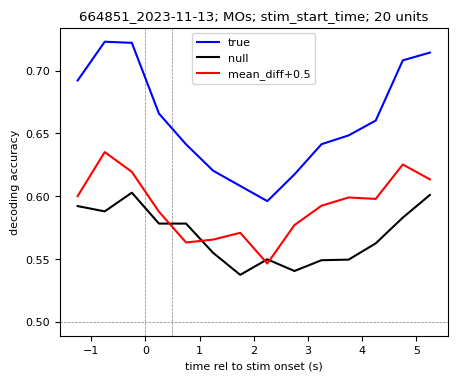

In [52]:
# sel_session="742903_2024-10-22"
sel_session="664851_2023-11-13"
# sel_session="670180_2023-07-27"
sel_structure="MOs"
sel_unit_subsample_size=20
sel_time_aligned_to="stim_start_time"
# sel_time_aligned_to="response_time"

# example_timebin_decoding=new_results_session_pd.query('session_id=="664851_2023-11-13" and structure=="ACAd" and \
#                                                     time_aligned_to=="stim_start_time" and unit_subsample_size==20').sort_values('bin_center')
example_timebin_decoding=new_results_session_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                     time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}').sort_values('bin_center')

fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['mean_true'], label='true', color='blue')
ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['median_null'], label='null', color='black')

ax.plot(example_timebin_decoding['bin_center'], example_timebin_decoding['mean_diff']+0.5, label='mean_diff+0.5', color='red')

# ax.set_ylim(0.5,1)

ax.set_xlabel('time rel to stim onset (s)')
ax.set_ylabel('decoding accuracy')
ax.legend()
ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units")

In [ ]:
#example area average from good sessions

sel_structure="ORBl"
time_aligned_to="stim_start_time"
min_n_passing_blocks=4

structure_accuracy=np.vstack(new_results_session_pd.query(
    'n_passing_blocks>=@min_n_passing_blocks and structure==@sel_structure and time_aligned_to==@time_aligned_to'
    ).sort_values(
        ['session_id','bin_center']
        ).groupby(['session_id'])['mean_diff'].apply(np.array).values)

bins=np.vstack(new_results_session_pd.query(
    'n_passing_blocks>=@min_n_passing_blocks and structure==@sel_structure and time_aligned_to==@time_aligned_to'
    ).sort_values(
        ['session_id','bin_center']
        ).groupby(['session_id'])['bin_center'].apply(np.array).values)[0]

n_sessions=len(structure_accuracy)

fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
ax.plot(bins,structure_accuracy.T, color='grey', alpha=0.5, linewidth=0.5)
ax.plot(bins,np.nanmean(structure_accuracy,axis=0), color='black', marker='.', linewidth=2)

ax.set_title(f"{sel_structure}; {n_sessions} sessions; {sel_unit_subsample_size} units")
ax.set_xlabel('time rel to '+time_aligned_to+' (s)')
ax.set_ylabel('decoding accuracy above null')

fig.tight_layout()

In [53]:
#average over areas from good sessions

time_aligned_to="stim_start_time"
min_n_passing_blocks=4

mean_timemod_accuracy_by_structure={
    'structure':[],
    'mean_diff':[],
    'mean_diff_std':[],
    'mean_diff_sem':[],
    'n_sessions':[],
}

for sel_structure in new_results_session_pd.query('n_passing_blocks>=4')['structure'].unique():
    structure_accuracy=np.vstack(new_results_session_pd.query(
        'n_passing_blocks>=@min_n_passing_blocks and structure==@sel_structure and time_aligned_to==@time_aligned_to'
        ).sort_values(
            ['session_id','bin_center']
            ).groupby(['session_id'])['mean_diff'].apply(np.array).values)

    bins=np.vstack(new_results_session_pd.query(
        'n_passing_blocks>=@min_n_passing_blocks and structure==@sel_structure and time_aligned_to==@time_aligned_to'
        ).sort_values(
            ['session_id','bin_center']
            ).groupby(['session_id'])['bin_center'].apply(np.array).values)[0]
    
    n_sessions=len(structure_accuracy)

    mean_timemod_accuracy_by_structure['structure'].append(sel_structure)
    mean_timemod_accuracy_by_structure['mean_diff'].append(np.nanmean(structure_accuracy,axis=0))
    mean_timemod_accuracy_by_structure['mean_diff_std'].append(np.nanstd(structure_accuracy,axis=0))
    mean_timemod_accuracy_by_structure['mean_diff_sem'].append(stats.sem(structure_accuracy, axis=0, nan_policy='omit'))
    mean_timemod_accuracy_by_structure['n_sessions'].append(n_sessions)

mean_timemod_accuracy_by_structure_df=pd.DataFrame(mean_timemod_accuracy_by_structure)

c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Anaconda3\envs\dr_ibl_analysis\Lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encounte

In [35]:
# mean_timemod_accuracy_by_structure_df

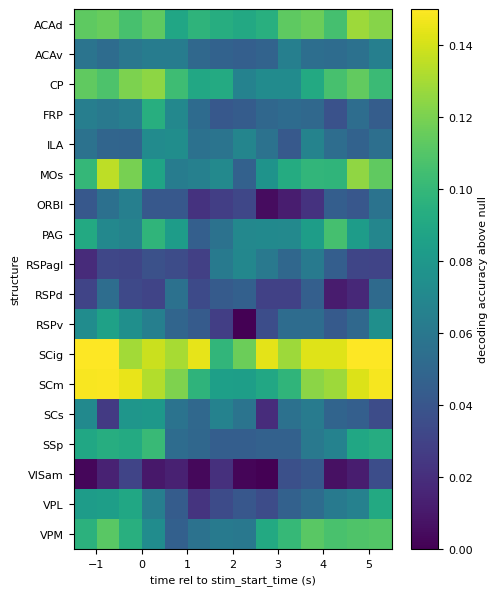

In [54]:
structure_matrix=np.vstack(mean_timemod_accuracy_by_structure_df.query('n_sessions>=1')['mean_diff'].values)
structure_labels=mean_timemod_accuracy_by_structure_df.query('n_sessions>=1')['structure'].values

fig,ax=plt.subplots(1,1,figsize=(5,6))
im=ax.imshow(structure_matrix, aspect='auto', cmap='viridis', vmin=0, vmax=0.15, extent=[bins[0]-0.25, bins[-1]+0.25, len(structure_labels), 0])
ax.set_yticks(np.arange(len(structure_labels))+0.5, structure_labels, ha='right')
# ax.set_xticks(np.arange(len(bins)))
# ax.set_xticklabels(bins)
ax.set_xlabel('time rel to '+time_aligned_to+' (s)')
ax.set_ylabel('structure')

# ax.set_title(f"mean decoding accuracy above null; {sel_unit_subsample_size} units; {min_n_passing_blocks} blocks")

fig.colorbar(im, ax=ax, label='decoding accuracy above null')
fig.tight_layout()

In [ ]:
bins

In [60]:

structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

predict_proba_wo_repeats = (
    pl.scan_parquet(results_path)
    #make new column that indicates whether a row is the sole recording from a structure in a session
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    #Grab only rows according to combine_multi_probe_rec toggle
    #Grab only rows that have is_all_trials == True, only these have predict_proba
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
    )
    #join on the units table to get total number of units per structure
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    .with_columns(
        pl.int_ranges(0, pl.col('predict_proba').list.len()).alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba', 'trial_index')
    .group_by('session_id', 'structure', 'unit_subsample_size', 'trial_index', 'bin_center', 'bin_size', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').mean(),
        pl.col('predict_proba').mean(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
    )
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                #iti column?
            )
            .select('session_id', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response')
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size', 'bin_center', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').first(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
        pl.col('predict_proba', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response').sort_by('trial_index'),

    )
    .sort('session_id','structure', 'unit_subsample_size', 'bin_center')
    # .group_by('session_id','structure')
    .collect(engine='streaming')
)

In [61]:
predict_proba_pd=predict_proba_wo_repeats.to_pandas()

In [7]:
predict_proba_pd.to_parquet(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\predict_proba_by_session.parquet", index=False)

In [ ]:
# predict_proba_pd=pd.read_parquet("/Users/ethan.mcbride/Data/DR/time_mod_binsize_0.5_sec_0_2025_05-19/predict_proba_by_session.parquet")
# predict_proba_pd=pd.read_parquet(r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\DR CO decoding results\time_mod_binsize_0.5_sec_0_2025_05-19\predict_proba_by_session.parquet")

In [ ]:
#add project column to predict_proba_pd and filter to just one time bin
predict_proba_temp=predict_proba_pd.query('bin_center==-0.25')

project_list = []
for rr, row in predict_proba_temp.iterrows():
    project= session_table.filter(
        pl.col('session_id') == row['session_id']
    )['project'][0]
    project_list.append(project)

predict_proba_temp['project'] = project_list

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_14528\554850620.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_proba_temp['project'] = project_list


In [14]:
predict_proba_temp.to_parquet(r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\time_mod_keep_units_consistent_0_2025-06-15\predict_proba_by_session_single_timebin.parquet", index=False)
predict_proba_temp

,session_id,structure,unit_subsample_size,bin_center,time_aligned_to,balanced_accuracy_test,total_n_units,predict_proba,trial_index,is_vis_rewarded,stim_name,is_response,project
2,620263_2022-07-26,ACAd,20,-0.25,stim_start_time,0.636546,111.0,"[0.8497706432830499, 0.8531392850669967, 0.952...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[vis1, vis1, vis1, vis1, vis1, vis2, vis1, vis...","[True, True, True, True, True, False, True, Tr...",Templeton
16,620263_2022-07-26,ACAv,20,-0.25,stim_start_time,0.593156,277.0,"[0.5788430380656661, 0.6073405065565846, 0.525...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[vis1, vis1, vis1, vis1, vis1, vis2, vis1, vis...","[True, True, True, True, True, False, True, Tr...",Templeton
30,620263_2022-07-26,CA1,20,-0.25,stim_start_time,0.604787,456.0,"[0.6728086079672706, 0.6342329586639969, 0.614...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[vis1, vis1, vis1, vis1, vis1, vis2, vis1, vis...","[True, True, True, True, True, False, True, Tr...",Templeton
44,620263_2022-07-26,DG,20,-0.25,stim_start_time,0.583497,168.0,"[0.48008389506319704, 0.5695107955136706, 0.53...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[vis1, vis1, vis1, vis1, vis1, vis2, vis1, vis...","[True, True, True, True, True, False, True, Tr...",Templeton
58,620263_2022-07-26,LSr,20,-0.25,stim_start_time,0.538686,68.0,"[0.5581318766850927, 0.4076373027457509, 0.503...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[vis1, vis1, vis1, vis1, vis1, vis2, vis1, vis...","[True, True, True, True, True, False, True, Tr...",Templeton
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31446,761583_2024-12-17,PO,20,-0.25,stim_start_time,0.534412,242.0,"[0.4440456839510623, 0.39192643590916615, 0.43...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, vis2,...","[True, True, True, True, True, False, True, Tr...",DynamicRouting
31460,761583_2024-12-17,SSp,20,-0.25,stim_start_time,0.555533,942.0,"[0.45647028179661786, 0.3142054758291465, 0.35...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, vis2,...","[True, True, True, True, True, False, True, Tr...",DynamicRouting
31474,761583_2024-12-17,VISam,20,-0.25,stim_start_time,0.564868,126.0,"[0.38809333133303037, 0.3847005654161307, 0.28...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, vis2,...","[True, True, True, True, True, False, True, Tr...",DynamicRouting
31488,761583_2024-12-17,VISli,20,-0.25,stim_start_time,0.519750,95.0,"[0.2016952767382615, 0.3607261302430998, 0.555...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[False, False, False, False, False, False, Fal...","[sound1, sound1, sound1, sound1, sound1, vis2,...","[True, True, True, True, True, False, True, Tr...",DynamicRouting


In [16]:
sel_session="664851_2023-11-13"
sel_structure="SCm"
sel_unit_subsample_size=20
sel_time_aligned_to='stim_start_time'

###hack used until we add trial_index to the results
if sel_time_aligned_to=='response_time':
    temp_trial_info=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                            time_aligned_to=="stim_start_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                            ).sort_values('bin_center').iloc[0]
    
    trial_index=temp_trial_info['trial_index'][temp_trial_info['is_response']]
    is_vis_context=temp_trial_info['is_vis_rewarded'][temp_trial_info['is_response']]
    stim_name=temp_trial_info['stim_name'][temp_trial_info['is_response']]
    is_response=temp_trial_info['is_response'][temp_trial_info['is_response']]

    example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                time_aligned_to=="response_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                                ).sort_values('bin_center').reset_index(drop=True)
    trial_index_list=[]
    is_vis_context_list=[]
    stim_name_list=[]
    is_response_list=[]
    for rr in range(len(example_area_results)):
        trial_index_list.append(trial_index)
        is_vis_context_list.append(is_vis_context)
        stim_name_list.append(stim_name)
        is_response_list.append(is_response)

    example_area_results['trial_index']=trial_index_list
    example_area_results['is_vis_rewarded']=is_vis_context_list
    example_area_results['stim_name']=stim_name_list
    example_area_results['is_response']=is_response_list

else:
    example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                ).sort_values('bin_center').reset_index(drop=True)

np.where(np.concatenate([[0],np.diff(example_area_results['is_vis_rewarded'].iloc[0])]))[0]

array([ 84, 169, 262, 350, 438], dtype=int64)

In [18]:
# example_area_results['is_vis_rewarded']

In [ ]:
# example_area_results.loc[rr,'trial_index']
# trial_index
# example_area_results.iloc[0]

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(5,4))

ax.plot(example_area_results['is_vis_context'].iloc[0],'k.')
ax.vlines(x=np.where(np.concatenate([[0],np.diff(example_area_results['is_vis_context'].iloc[0])]))[0],ymin=-.1,ymax=1.1, color='red', linestyle='--', linewidth=0.5)

In [ ]:
sel_trial=92
fig,ax=plt.subplots(1,1,figsize=(5,4))
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.plot(example_area_results['bin_center'],np.vstack(example_area_results['predict_proba'].values)[:,sel_trial], 'k.-')
ax.set_ylim(0,1)

ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units; \n \
             trial {example_area_results['trial_index'].iloc[0][sel_trial]}; {example_area_results['stim_name'].iloc[0][sel_trial]}; is_vis_context={example_area_results['is_vis_context'].iloc[0][sel_trial]}")

In [ ]:
# is_vis_context

In [ ]:
predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

fig,ax=plt.subplots(1,1,figsize=(6,15))
im=ax.imshow(predict_proba_stack, aspect='auto', interpolation='none', extent=[-0.4, 2.0, predict_proba_stack.shape[0],0], cmap='bwr', vmin=0, vmax=1)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('predict_proba')

#make tickmarks on right side for false alarms
is_vis_context=example_area_results['is_vis_context'].values[0]
stim_name=example_area_results['stim_name'].values[0]
is_response=example_area_results['is_response'].values[0]

is_false_alarm=(
    is_vis_context & (stim_name == 'sound1') & (is_response == True) |
    ~is_vis_context & (stim_name == 'vis1') & (is_response == True)
)

is_hit=(
    is_vis_context & (stim_name == 'vis1') & (is_response == True) |
    ~is_vis_context & (stim_name == 'sound1') & (is_response == True)
)

is_correct_reject=(
    is_vis_context & (stim_name == 'sound1') & (is_response == False) |
    ~is_vis_context & (stim_name == 'vis1') & (is_response == False)
)

is_miss=(
    is_vis_context & (stim_name == 'vis1') & (is_response == False) |
    ~is_vis_context & (stim_name == 'sound1') & (is_response == False)
)


ax2=ax.twinx()
# ax2.set_ylim(0, predict_proba_stack.shape[0])
ax2.set_ylim(predict_proba_stack.shape[0],0)

ax2.plot([2.1]*len(np.where(is_hit)[0]), np.where(is_hit)[0]+0.5, 'g_', label='hit', clip_on=False, markersize=12)
ax2.plot([2.1]*len(np.where(is_correct_reject)[0]), np.where(is_correct_reject)[0]+0.5, 'b_', label='correct reject', clip_on=False, markersize=12)
ax2.plot([2.1]*len(np.where(is_false_alarm)[0]), np.where(is_false_alarm)[0]+0.5, 'r_', label='false alarm', clip_on=False, markersize=12)
ax2.plot([2.1]*len(np.where(is_miss)[0]), np.where(is_miss)[0]+0.5, 'k_', label='miss', clip_on=False, markersize=12)

# ax2.set_yticks(np.where(is_false_alarm)[0])
ax2.set_yticklabels([])

#plot context switch lines
context_switches=np.where(np.concatenate([[0],np.diff(example_area_results['is_vis_context'].iloc[0])]))[0]
for rr in range(len(context_switches)):
    ax2.axhline(y=context_switches[rr], color='k', linestyle='-', linewidth=2.0)

ax.set_xlabel('time rel to stim onset (s)')
ax.set_ylabel('trials')
ax.set_title(f"{sel_session}; {sel_structure}; {sel_time_aligned_to}; {sel_unit_subsample_size} units")

In [ ]:
# aggregate predict proba in a smart way over trials & structures


# switches (contingent, non-contingent) + pre,post block dprime + trials_since_switch


# rewards (lick & get reward) + block dprime + is_instruction_trial


# reward prediction errors (lick & get no reward, no lick & get reward?) + block dprime + is_instruction_trial


# average non target, non response



In [62]:

def get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to):
    """
    Get the results for a specific session and structure.
    """
    
    if sel_time_aligned_to=='response_time':
        temp_trial_info=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                time_aligned_to=="stim_start_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                                ).sort_values('bin_center').iloc[0]
        
        trial_index=temp_trial_info['trial_index'][temp_trial_info['is_response']]
        is_vis_rewarded=temp_trial_info['is_vis_rewarded'][temp_trial_info['is_response']]
        stim_name=temp_trial_info['stim_name'][temp_trial_info['is_response']]
        is_response=temp_trial_info['is_response'][temp_trial_info['is_response']]

        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="response_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                                    ).sort_values('bin_center').reset_index(drop=True)
        trial_index_list=[]
        is_vis_rewarded_list=[]
        stim_name_list=[]
        is_response_list=[]
        for rr in range(len(example_area_results)):
            trial_index_list.append(trial_index)
            is_vis_rewarded_list.append(is_vis_rewarded)
            stim_name_list.append(stim_name)
            is_response_list.append(is_response)

        example_area_results['trial_index']=trial_index_list
        example_area_results['is_vis_rewarded']=is_vis_rewarded_list
        example_area_results['stim_name']=stim_name_list
        example_area_results['is_response']=is_response_list

    else:
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                    ).sort_values('bin_center').reset_index(drop=True)
        
    #get context switches
    is_context_switch=np.concatenate([[0],np.diff(example_area_results['is_vis_rewarded'].iloc[0])]).astype(bool)
    context_switch_list=[]
    for rr in range(len(example_area_results)):
        context_switch_list.append(is_context_switch)
    example_area_results['is_context_switch']=context_switch_list


    return example_area_results

In [63]:
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect()#.to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect()#.to_pandas()

In [ ]:
predict_proba_pd.query('session_id=="670180_2023-07-27"')['structure'].unique()

Text(0.5, 1.0, '664851_2023-11-13 correlation between ACAd and SCm at 1.25s: r=0.441, p=5.854e-25')

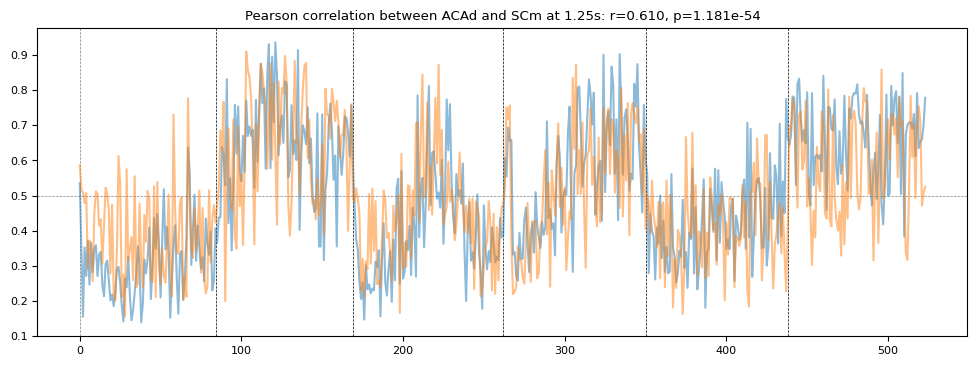

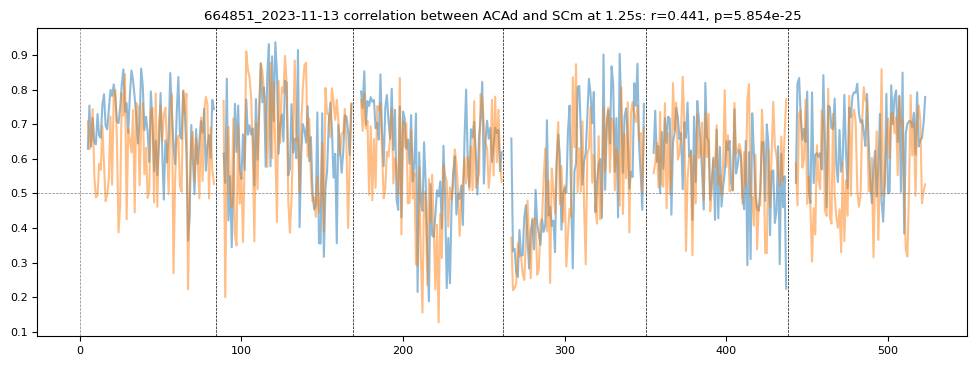

In [79]:
sel_session="664851_2023-11-13"
sel_structure_0="ACAd"
sel_structure_1="SCm"
# sel_session="670180_2023-07-27"
# sel_structure_0="PL"
# sel_structure_1="ACAd"
sel_time_bin=1.25
correction='flip_aud' #'subtract_mean' or 'flip_aud'
excl_instruction_trials=True
sel_unit_subsample_size=20
sel_time_aligned_to='stim_start_time'

structure_results_0=get_session_structure_results(predict_proba_pd, sel_session, sel_structure_0, sel_unit_subsample_size, sel_time_aligned_to)
structure_results_1=get_session_structure_results(predict_proba_pd, sel_session, sel_structure_1, sel_unit_subsample_size, sel_time_aligned_to)

predict_proba_0=structure_results_0.query(f'bin_center==({sel_time_bin})')['predict_proba'].values[0]
predict_proba_1=structure_results_1.query(f'bin_center==({sel_time_bin})')['predict_proba'].values[0]

session_trials=all_trials.filter(pl.col('session_id').eq(sel_session)).sort('trial_index')

block_switches=session_trials.to_pandas().query('is_block_switch')['trial_index'].values

r,p=stats.pearsonr(predict_proba_0, predict_proba_1)

fig,ax=plt.subplots(1,1,figsize=(12,4))

for bb in block_switches:
    ax.axvline(x=bb, color='black', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.plot(predict_proba_0, label=sel_structure_0, color='tab:blue', alpha=0.5)
ax.plot(predict_proba_1, label=sel_structure_1, color='tab:orange', alpha=0.5)
ax.set_title(f"Pearson correlation between {sel_structure_0} and {sel_structure_1} at {sel_time_bin}s: r={r:.3f}, p={p:.3e}")



if (
    session_trials['block_index'].n_unique() == 1
    and not (
        session_table.filter(
            pl.col('session_id') == session_trials['session_id'][0],
            pl.col('is_templeton'),
        )
    ).is_empty()
):
    print(f'Adding dummy context labels for Templeton session {sel_session}')
    session_trials = (
        session_trials
        .with_columns(
            pl.col('start_time').sub(pl.col('start_time').min().over('session_id')).truediv(10*60).floor().clip(0, 5).alias('block_index')
            # short 7th block will sometimes be present: merge into 6th with clip
        )
        .with_columns(
            pl.when(pl.col('block_index').mod(2).eq(random.choice([0, 1])))
            .then(pl.lit('vis'))
            .otherwise(pl.lit('aud'))
            .alias('rewarded_modality')
        )
        .sort('trial_index')
    )

session_trials = session_trials.to_pandas()

session_trials['predict_proba_0']=predict_proba_0
session_trials['predict_proba_1']=predict_proba_1

if excl_instruction_trials:
    # session_trials=session_trials.query('~is_instruction').reset_index(drop=True)
    #replace is_instruction trials predict_proba with nan
    session_trials['predict_proba_0'] = session_trials['predict_proba_0'].where(~session_trials['is_instruction'], np.nan)
    session_trials['predict_proba_1'] = session_trials['predict_proba_1'].where(~session_trials['is_instruction'], np.nan)

corrected_predict_proba_0 = []
corrected_predict_proba_1 = []
for bb in session_trials['block_index'].unique():
    block_trials=session_trials.query(f'block_index=={bb}')
    if correction=='flip_aud':
        if block_trials['rewarded_modality'].values[0]=='vis':
            corrected_predict_proba_0.append(block_trials['predict_proba_0'].values)
            corrected_predict_proba_1.append(block_trials['predict_proba_1'].values)
        elif block_trials['rewarded_modality'].values[0]=='aud':
            corrected_predict_proba_0.append(1 - block_trials['predict_proba_0'].values)
            corrected_predict_proba_1.append(1 - block_trials['predict_proba_1'].values)
    elif correction=='subtract_mean':
        corrected_predict_proba_0.append(block_trials['predict_proba_0'].values - np.nanmean(block_trials['predict_proba_0'].values))
        corrected_predict_proba_1.append(block_trials['predict_proba_1'].values - np.nanmean(block_trials['predict_proba_1'].values))

corrected_predict_proba_0 = np.concatenate(corrected_predict_proba_0)
corrected_predict_proba_1 = np.concatenate(corrected_predict_proba_1)

r,p=stats.pearsonr(corrected_predict_proba_0[~np.isnan(corrected_predict_proba_0)], corrected_predict_proba_1[~np.isnan(corrected_predict_proba_1)])

fig,ax=plt.subplots(1,1,figsize=(12,4))
for bb in block_switches:
    ax.axvline(x=bb, color='black', linestyle='--', linewidth=0.5)
if correction=='flip_aud':
    ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
elif correction=='subtract_mean':
    ax.axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.plot(corrected_predict_proba_0, label=sel_structure_0, color='tab:blue', alpha=0.5)
ax.plot(corrected_predict_proba_1, label=sel_structure_1, color='tab:orange', alpha=0.5)
ax.set_title(f"{sel_session} correlation between {sel_structure_0} and {sel_structure_1} at {sel_time_bin}s: r={r:.3f}, p={p:.3e}")



In [ ]:
predict_proba_pd.query(f'session_id=="{sel_session}"')['structure'].unique()

In [107]:
session_table['issues'].eq("").mean()

0.9484126984126984

In [108]:
# get predict proba from each structure in this session (at selected time bin), correct it and append to the trials table

# sel_session="664851_2023-11-13"
sel_time_bin=-0.25
correction='flip_aud' #'subtract_mean' or 'flip_aud'
excl_instruction_trials=True
sel_unit_subsample_size=20
sel_time_aligned_to='stim_start_time'

predict_proba_corr_dict={
    'session_id':[],
    'structure_0':[],
    'structure_1':[],
    'r':[],
    'p':[],
}

for sel_session in session_table.filter(pl.col('project')=="DynamicRouting",pl.col('is_production'),
                                        pl.col('issues').eq(""))['session_id'].unique().to_list():
# for sel_session in session_table.filter(pl.col('project')=="Templeton",pl.col('issues').eq(""))['session_id'].unique().to_list():

    session_structures=predict_proba_pd.query(f'session_id=="{sel_session}"')['structure'].unique()
    session_trials=all_trials.filter(pl.col('session_id').eq(sel_session)).sort('trial_index')

    if (
        session_trials['block_index'].n_unique() == 1
        and not (
            session_table.filter(
                pl.col('session_id') == session_trials['session_id'][0], 
                pl.col('is_templeton'),
            )
        ).is_empty()
    ):
        print(f'Adding dummy context labels for Templeton session {sel_session}')
        session_trials = (
            session_trials
            .with_columns(
                pl.col('start_time').sub(pl.col('start_time').min().over('session_id')).truediv(10*60).floor().clip(0, 5).alias('block_index')
                # short 7th block will sometimes be present: merge into 6th with clip
            )
            .with_columns(
                pl.when(pl.col('block_index').mod(2).eq(random.choice([0, 1])))
                .then(pl.lit('vis'))
                .otherwise(pl.lit('aud'))
                .alias('rewarded_modality')
            )
            .sort('trial_index')
        )

    session_trials = session_trials.to_pandas()

    for sel_structure in session_structures:
        structure_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)
        predict_proba=structure_results.query(f'bin_center==({sel_time_bin})')['predict_proba'].values[0]

        if len(predict_proba)!=len(session_trials):
            print(f"Skipping {sel_session}, {sel_structure} due to mismatch in number of trials between trials and predict_proba")
            predict_proba=np.array([np.nan]*len(session_trials))

        temp_combined_trials=session_trials.copy()
        temp_combined_trials['predict_proba']=predict_proba

        corrected_predict_proba = []
        for bb in temp_combined_trials['block_index'].unique():
            block_trials=temp_combined_trials.query(f'block_index=={bb}')
            if correction=='flip_aud':
                if block_trials['rewarded_modality'].values[0]=='vis':
                    corrected_predict_proba.append(block_trials['predict_proba'].values)
                elif block_trials['rewarded_modality'].values[0]=='aud':
                    corrected_predict_proba.append(1 - block_trials['predict_proba'].values)
            elif correction=='subtract_mean':
                corrected_predict_proba.append(block_trials['predict_proba'].values - np.nanmean(block_trials['predict_proba'].values))

        corrected_predict_proba = np.concatenate(corrected_predict_proba)

        session_trials[f'{sel_structure}_predict_proba']=corrected_predict_proba

    # add a "behavior" column
    # -1 for response to non-rewarded target
    # 1 for no response to non-rewarded target
    # 0 for other stimuli
    session_trials['choice_predict_proba']=np.nan
    #false alarms
    session_trials.loc[
        (session_trials['is_response']==True) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
        (session_trials['is_response']==True) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
        ,'choice_predict_proba']=-1
    #correct rejects
    session_trials.loc[
        (session_trials['is_response']==False) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='aud')|
        (session_trials['is_response']==False) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='vis')
        ,'choice_predict_proba']=1
    # #hits
    # session_trials.loc[
    #     (session_trials['is_response']==True) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='vis')|
    #     (session_trials['is_response']==True) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='aud')
    #     ,'choice_predict_proba']=1
    # #misses
    # session_trials.loc[
    #     (session_trials['is_response']==False) & (session_trials['stim_name']=='vis1') & (session_trials['rewarded_modality']=='vis')|
    #     (session_trials['is_response']==False) & (session_trials['stim_name']=='sound1') & (session_trials['rewarded_modality']=='aud')
    #     ,'choice_predict_proba']=1

    if excl_instruction_trials:
        session_trials=session_trials.query('~is_instruction').reset_index(drop=True)

    for col0 in session_trials.filter(like='predict_proba').columns:
        for col1 in session_trials.filter(like='predict_proba').columns:
            if col0!=col1:
                if (np.sum(np.isnan(session_trials[col0]))>0)|(np.sum(np.isnan(session_trials[col1]))>0):
                    notnanidx=~np.isnan(session_trials[col0])&~np.isnan(session_trials[col1])
                    if sum(notnanidx)==0:
                        r=np.nan
                        p=np.nan
                    else:
                        r,p=stats.pearsonr(session_trials[col0][notnanidx], session_trials[col1][notnanidx])
                else:
                    r,p=stats.pearsonr(session_trials[col0], session_trials[col1])
                # print(f"{col0} vs {col1}: r={r:.3f}, p={p:.3e}")
                predict_proba_corr_dict['session_id'].append(sel_session)
                predict_proba_corr_dict['structure_0'].append(col0.replace('_predict_proba',''))
                predict_proba_corr_dict['structure_1'].append(col1.replace('_predict_proba',''))
                predict_proba_corr_dict['r'].append(r)
                predict_proba_corr_dict['p'].append(p)

predict_proba_corr_df=pd.DataFrame(predict_proba_corr_dict)

Skipping 644866_2023-02-07, CA1 due to mismatch in number of trials between trials and predict_proba
Skipping 644866_2023-02-07, DG due to mismatch in number of trials between trials and predict_proba
Skipping 644866_2023-02-07, Eth due to mismatch in number of trials between trials and predict_proba
Skipping 644866_2023-02-07, LP due to mismatch in number of trials between trials and predict_proba
Skipping 644866_2023-02-07, MGd due to mismatch in number of trials between trials and predict_proba
Skipping 644866_2023-02-07, MGv due to mismatch in number of trials between trials and predict_proba
Skipping 644866_2023-02-07, MOs due to mismatch in number of trials between trials and predict_proba
Skipping 644866_2023-02-07, POL due to mismatch in number of trials between trials and predict_proba
Skipping 644866_2023-02-07, PoT due to mismatch in number of trials between trials and predict_proba
Skipping 644866_2023-02-07, ProS due to mismatch in number of trials between trials and predi

In [48]:
# notnanidx.sum()

In [109]:
# session_trials
predict_proba_corr_df

,session_id,structure_0,structure_1,r,p
0,703882_2024-04-22,ACAd,CP,0.107206,2.552372e-02
1,703882_2024-04-22,ACAd,FRP,0.006577,8.913336e-01
2,703882_2024-04-22,ACAd,MOs,0.302344,1.262684e-10
3,703882_2024-04-22,ACAd,ORBl,0.318464,1.098352e-11
4,703882_2024-04-22,ACAd,ORBvl,0.181099,1.486553e-04
...,...,...,...,...,...
31911,636766_2023-01-25,behavior,RSPagl,0.105212,2.785038e-01
31912,636766_2023-01-25,behavior,SUB,0.151092,1.185474e-01
31913,636766_2023-01-25,behavior,VISam,0.120670,2.135013e-01
31914,636766_2023-01-25,behavior,VISp,-0.004344,9.644106e-01


In [ ]:
# excl_instruction_trials=True
# if excl_instruction_trials:
#     session_trials=session_trials.query('~is_instruction').reset_index(drop=True)

# predict_proba_corr_dict={
#     'session_id':sel_session,
#     'structure_0':[],
#     'structure_1':[],
#     'r':[],
#     'p':[],
# }

# for col0 in session_trials.filter(like='predict_proba').columns:
#     for col1 in session_trials.filter(like='predict_proba').columns:
#         if col0!=col1:
#             r,p=stats.pearsonr(session_trials[col0], session_trials[col1])
#             # print(f"{col0} vs {col1}: r={r:.3f}, p={p:.3e}")
#             predict_proba_corr_dict['structure_0'].append(col0.replace('_predict_proba',''))
#             predict_proba_corr_dict['structure_1'].append(col1.replace('_predict_proba',''))
#             predict_proba_corr_dict['r'].append(r)
#             predict_proba_corr_dict['p'].append(p)
            
# predict_proba_corr_df=pd.DataFrame(predict_proba_corr_dict)
# predict_proba_corr_df

In [38]:
(predict_proba_corr_df[['structure_0','structure_1']].value_counts()['behavior']>3).sum()

75

In [82]:
unique_combos=predict_proba_corr_df[['structure_0','structure_1']].drop_duplicates().reset_index(drop=True)

mean_corr=unique_combos.copy()
mean_corr['mean_r']=np.nan
mean_corr['n_sessions']=0
for rr in range(len(unique_combos)):
    sel_structure_0=unique_combos.loc[rr,'structure_0']
    sel_structure_1=unique_combos.loc[rr,'structure_1']
    temp_df=predict_proba_corr_df.query(f'structure_0==@sel_structure_0 and structure_1==@sel_structure_1')
    mean_corr.loc[rr,'mean_r']=temp_df['r'].mean()
    mean_corr.loc[rr,'n_sessions']=len(temp_df)


In [83]:
mean_corr.query('n_sessions>=3').sort_values('mean_r', ascending=False) #[['structure_0','structure_1']].value_counts()['ACAd'].sum()

,structure_0,structure_1,mean_r,n_sessions
1140,SCiw,SCm,0.913219,21
1149,SCm,SCiw,0.913219,21
819,SCm,SCig,0.863899,21
810,SCig,SCm,0.863899,21
5420,ECT6a,ECT,0.782646,5
...,...,...,...,...
5020,VISrl,behavior,0.016620,3
1614,behavior,ACB,0.015446,10
1455,ACB,behavior,0.015446,10
3723,behavior,TRS,0.005168,5


In [84]:
# (predict_proba_corr_df[['structure_0','structure_1']].value_counts()['ACAd']>3)
(predict_proba_corr_df[['structure_0','structure_1']].value_counts()['ACAd']>2).sum()

63

In [156]:
# unique_structures=predict_proba_pd['structure'].unique()
unique_structures=predict_proba_corr_df['structure_0'].sort_values().unique()

unique_structures=unique_structures[~np.isin(unique_structures, ['SCop', 'SCsg', 'SCzo', 'SCig', 'SCiw', 'SCdg', 'SCdw', 'ECT5', 'ECT6a',
                                                                 'OLF', 'HPF', 'CTXsp', 'STR', 'PAL', 'TH', 'HY', 'MB', 'P', 'MY', 'CB', 
                                                                 'fiber tracts', 'scwm', 'VL', 'V3', 'V4'])]

combo_value_counts=predict_proba_corr_df[['structure_0','structure_1']].value_counts()

incl_structures=[]
for st in unique_structures:
    if (predict_proba_corr_df[['structure_0','structure_1']].value_counts()[st]>=3).sum()>=30:
        incl_structures.append(st)

incl_structures=np.sort(incl_structures)

#build correlation matrix from this dataframe
corr_matrix=np.full((len(incl_structures), len(incl_structures)), np.nan)
for rr, sel_structure_0 in enumerate(incl_structures):
    for cc, sel_structure_1 in enumerate(incl_structures):
        if sel_structure_0==sel_structure_1:
            corr_matrix[rr,cc]=np.nan
        else:
            temp_df=predict_proba_corr_df.query(f'structure_0=="{sel_structure_0}" and structure_1=="{sel_structure_1}"')
            #only save if at least 3 sessions
            if len(temp_df)>=3:
                corr_matrix[rr,cc]=temp_df['r'].mean()

# corr_matrix[np.isnan(corr_matrix)]=np.nanmean(corr_matrix)

In [157]:
unique_structures

array(['ACAd', 'ACAv', 'ACB', 'AD', 'AId', 'AIp', 'AIv', 'AMd', 'AMv',
       'AON', 'APN', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'AV', 'BST', 'CA1',
       'CA2', 'CA3', 'CEAm', 'CL', 'CLA', 'CP', 'CS', 'DG', 'DP', 'DTN',
       'ECT', 'ECT2/3', 'ECT6b', 'ENTl', 'ENTm', 'EPd', 'Eth', 'FF',
       'FRP', 'GPe', 'GPi', 'GRN', 'GU', 'IAD', 'ICd', 'ICe', 'IG', 'ILA',
       'LA', 'LD', 'LGd', 'LGv', 'LH', 'LHA', 'LP', 'LSc', 'LSr', 'LSv',
       'MD', 'MGd', 'MGm', 'MGv', 'MH', 'MOB', 'MOp', 'MOs', 'MPT', 'MRN',
       'MS', 'NB', 'NOT', 'OP', 'ORBl', 'ORBm', 'ORBvl', 'OT', 'PAG',
       'PAR', 'PCN', 'PERI', 'PF', 'PIR', 'PL', 'PO', 'POL', 'POST', 'PP',
       'PPT', 'PR', 'PRE', 'PSTN', 'PoT', 'ProS', 'RN', 'RSPagl', 'RSPd',
       'RSPv', 'RT', 'SAG', 'SCm', 'SCs', 'SEZ', 'SF', 'SGN', 'SH', 'SMT',
       'SNr', 'SSp', 'SSs', 'SUB', 'TEa', 'TRS', 'TTd', 'VAL', 'VISC',
       'VISa', 'VISal', 'VISam', 'VISl', 'VISli', 'VISp', 'VISpl',
       'VISpm', 'VISpor', 'VISrl', 'VM', 'VPL', 'VPLpc', '

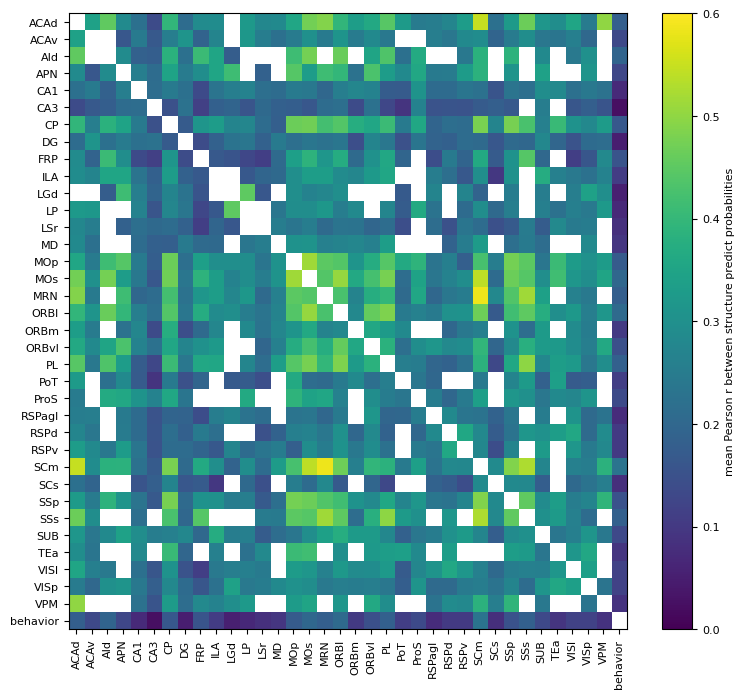

In [169]:
fig,ax=plt.subplots(1,1,figsize=(9,8))
im=ax.imshow(corr_matrix, aspect='auto', cmap='viridis', vmin=0, vmax=0.6, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), incl_structures, rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), incl_structures)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')

In [114]:
thalamus_structures=[
    'AD', 'AMd', 'AMv', 'AV', 'BST', 'CL', 'LD', 'LGd', 'LGv', 'LP', 'MD', 'MGd', 'MGm', 'MGv', 
    'PO', 'POL', 'RT', 'SGN', 'VAL','VL', 'VM', 'VPL', 'VPLpc', 'VPM', 'VPMpc'
    ]

In [ ]:
#custom ordering of structures?

structure_ordering=(
    'FRP','ACAd','ACAv','PL','ILA','ORBl','ORBm','ORBvl',
    'AId','AIv','AIp','GU','VISC','TEa','PERI','ECT',
    'MOs','MOp','SSp','SSs',
    'VISal','VISl','VISp','VISpl','VISli','VISpor','VISrl',
    'VISa','VISam','VISpm','RSPagl','RSPd','RSPv',
    'AUDd','AUDp','AUDpo','AUDv',
    
)

structure_tag=(
    'prefrontal','prefrontal','prefrontal','prefrontal','prefrontal','prefrontal','prefrontal','prefrontal',
    'lateral','lateral','lateral','lateral','lateral','lateral','lateral','lateral',
    'somatomotor','somatomotor','somatomotor','somatomotor',
    'visual','visual','visual','visual','visual','visual','visual',
    'medial','medial','medial','medial','medial','medial',
    'auditory','auditory','auditory','auditory',

)

In [172]:
from sklearn.cluster import SpectralCoclustering
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import consensus_score

cluster_corr_matrix=corr_matrix.copy()

# for rowind in range(cluster_corr_matrix.shape[0]):
#     for colind in range(cluster_corr_matrix.shape[1]):
#         if rowind==colind:
#             cluster_corr_matrix[rowind, colind] = np.nanmean(cluster_corr_matrix)
#         else:
#             cluster_corr_matrix[rowind, colind] = np.nanmean([cluster_corr_matrix[rowind, :],cluster_corr_matrix[:, colind]])
cluster_corr_matrix[np.isnan(cluster_corr_matrix)]=np.nanmean(cluster_corr_matrix)

data=cluster_corr_matrix.copy()

model = SpectralBiclustering(n_clusters=2, method="log", random_state=0)
# model = SpectralCoclustering(n_clusters=2, random_state=0)
model.fit(data)

# score = consensus_score(model.biclusters_, (rows[:, row_idx], columns[:, col_idx]))

# print("consensus score: {:.3f}".format(score))

fit_data = corr_matrix[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

In [131]:
##TODO: Figure out a clustering score
## try other clustering methods?
### PROPERLY deal with nans

In [132]:
# model.column_labels_[np.argsort(model.column_labels_)]

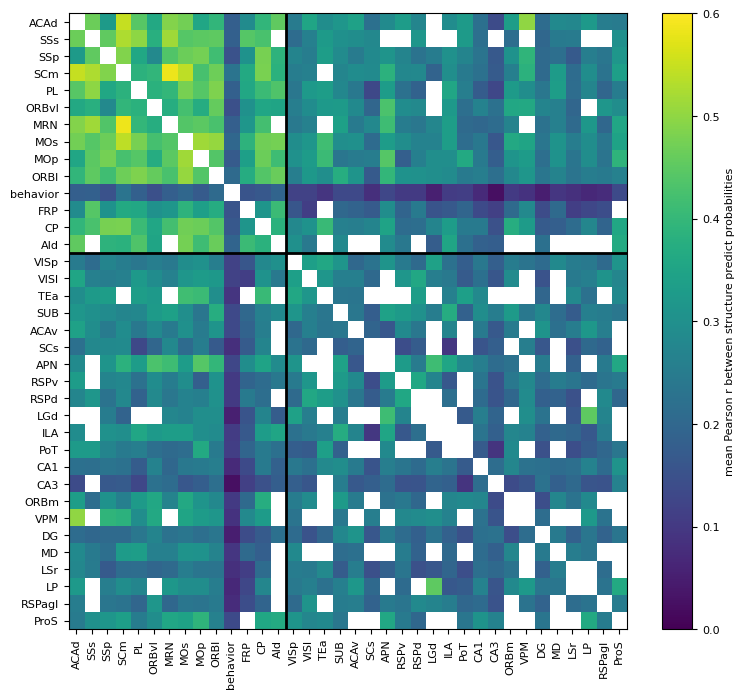

In [173]:
fig,ax=plt.subplots(1,1,figsize=(9,8))
im=ax.imshow(fit_data, aspect='auto', cmap='viridis', vmin=0, vmax=0.6, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
ax.set_xticks(np.arange(len(incl_structures)), incl_structures[np.argsort(model.row_labels_)], rotation=90)
ax.set_yticks(np.arange(len(incl_structures)), incl_structures[np.argsort(model.column_labels_)])

row_labels = model.row_labels_
sorted_row_labels = row_labels[np.argsort(row_labels)]
cluster_borders = np.where(np.diff(sorted_row_labels) != 0)[0] + 0.5

for xx in cluster_borders:
    ax.axvline(x=xx, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=xx, color='black', linestyle='-', linewidth=2)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')

In [ ]:
# all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect().to_pandas()

In [186]:
# import sklearn.cluster.HDBSCAN as hdbscan
import hdbscan

cluster_corr_matrix=corr_matrix.copy()
data=cluster_corr_matrix.copy()

model = hdbscan.HDBSCAN(min_cluster_size=2)

# model.fit_predict(data)


In [208]:
#from stackexchange
from sklearn.cluster import KMeans

def kmeans_missing(X, n_clusters, max_iter=10):
    """Perform K-Means clustering on data with missing values.

    Args:
      X: An [n_samples, n_features] array of data to cluster.
      n_clusters: Number of clusters to form.
      max_iter: Maximum number of EM iterations to perform.

    Returns:
      labels: An [n_samples] vector of integer labels.
      centroids: An [n_clusters, n_features] array of cluster centroids.
      X_hat: Copy of X with the missing values filled in.
    """

    # Initialize missing values to their column means
    missing = ~np.isfinite(X)
    mu = np.nanmean(X, 0, keepdims=1)
    X_hat = np.where(missing, mu, X)

    for i in range(max_iter):
        if i > 0:
            # initialize KMeans with the previous set of centroids. this is much
            # faster and makes it easier to check convergence (since labels
            # won't be permuted on every iteration), but might be more prone to
            # getting stuck in local minima.
            cls = KMeans(n_clusters, init=prev_centroids)
        else:
            # do multiple random initializations in parallel
            cls = KMeans(n_clusters)

        # perform clustering on the filled-in data
        labels = cls.fit_predict(X_hat)
        centroids = cls.cluster_centers_

        # fill in the missing values based on their cluster centroids
        X_hat[missing] = centroids[labels][missing]

        # when the labels have stopped changing then we have converged
        if i > 0 and np.all(labels == prev_labels):
            print("Converged after {} iterations".format(i))
            break

        prev_labels = labels
        prev_centroids = cls.cluster_centers_

    return labels, centroids, X_hat

In [189]:
X_hat

array([[0.41328664, 0.34372952, 0.45461562, ..., 0.24957196, 0.50126102,
        0.18190533],
       [0.34372952, 0.23770184, 0.26862947, ..., 0.20347236, 0.24649911,
        0.13208265],
       [0.45461562, 0.26606559, 0.39432768, ..., 0.30027939, 0.35043013,
        0.19231294],
       ...,
       [0.24957196, 0.20347236, 0.30027939, ..., 0.23731572, 0.23097941,
        0.11777145],
       [0.50126102, 0.26606559, 0.39432768, ..., 0.23097941, 0.35043013,
        0.08804848],
       [0.18190533, 0.13208265, 0.19231294, ..., 0.11777145, 0.08804848,
        0.09597253]])

Converged after 1 iterations


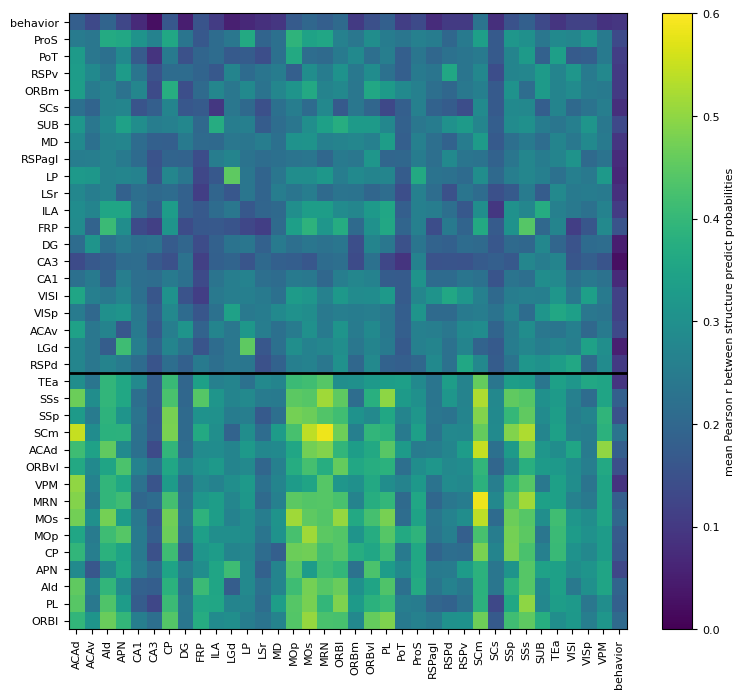

In [ ]:
data=corr_matrix.copy()
labels, centroids, X_hat = kmeans_missing(data, n_clusters=2)

fit_data=X_hat[np.argsort(labels)]

fig,ax=plt.subplots(1,1,figsize=(9,8))
im=ax.imshow(fit_data, aspect='auto', cmap='viridis', vmin=0, vmax=0.6, extent=[-0.5,len(incl_structures)-0.5,len(incl_structures)-0.5,-0.5])
# ax.set_xticks(np.arange(len(labels)), incl_structures[np.argsort(labels)], rotation=90)
ax.set_xticks(np.arange(len(labels)), incl_structures, rotation=90)
ax.set_yticks(np.arange(len(labels)), incl_structures[np.argsort(labels)])

sorted_row_labels = labels[np.argsort(labels)]
cluster_borders = np.where(np.diff(sorted_row_labels) != 0)[0] + 0.5

for xx in cluster_borders:
    # ax.axvline(x=xx, color='black', linestyle='-', linewidth=2)
    ax.axhline(y=xx, color='black', linestyle='-', linewidth=2)

#colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('mean Pearson r between structure predict probabilities')

In [198]:
data[np.argsort(labels)][np.argsort(labels)]

array([[       nan, 0.34372952, 0.45461562, ..., 0.24957196, 0.50126102,
        0.18190533],
       [0.29090189, 0.27067851, 0.35223879, ..., 0.22414931, 0.26499191,
        0.10634396],
       [0.21322093, 0.31029387, 0.22178466, ..., 0.20920557, 0.21507033,
        0.04927557],
       ...,
       [0.28699121, 0.16233933, 0.28868428, ..., 0.31111611,        nan,
        0.12737424],
       [0.39552127, 0.31060356, 0.46204905, ..., 0.25754305, 0.31469077,
        0.2064889 ],
       [0.18190533, 0.13208265, 0.19231294, ..., 0.11777145, 0.08804848,
               nan]])

In [191]:
fit_data

array([0.09597253, 0.26216057, 0.18097039, 0.23286637, 0.23732469,
       0.16980526, 0.25296141, 0.22193154, 0.2181599 , 0.23657891,
       0.19264042, 0.21101212, 0.16576523, 0.19721209, 0.17037448,
       0.21976974, 0.23993146, 0.23731572, 0.23770184, 0.23860723,
       0.22306359, 0.34070535, 0.4409266 , 0.3996248 , 0.45836091,
       0.41328664, 0.37489249, 0.35043013, 0.44079946, 0.45091647,
       0.42642657, 0.41427428, 0.35658108, 0.39432768, 0.40465658,
       0.42447325])

In [146]:
np.mean(np.isnan(data),axis=1)

array([0.05555556, 0.16666667, 0.36111111, 0.22222222, 0.02777778,
       0.08333333, 0.02777778, 0.02777778, 0.08333333, 0.13888889,
       0.36111111, 0.19444444, 0.13888889, 0.30555556, 0.02777778,
       0.02777778, 0.11111111, 0.02777778, 0.22222222, 0.08333333,
       0.05555556, 0.22222222, 0.27777778, 0.16666667, 0.13888889,
       0.11111111, 0.05555556, 0.25      , 0.02777778, 0.27777778,
       0.02777778, 0.38888889, 0.11111111, 0.02777778, 0.36111111,
       0.02777778])

In [ ]:
# all_performance.query(f'session_id=="{sel_session}"').columns

In [ ]:
#get predict_proba relative to switches, make new table

# sel_session="664851_2023-11-13"
# sel_structure="SCm"
sel_unit_subsample_size=20
sel_time_aligned_to='stim_start_time'

get_trials_rel_to_switch=[-1,0,1,2,3,4]
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect().to_pandas()

context_switch_table={
    'session_id':[],
    'structure':[],
    'predict_proba':[],
    'bin_centers':[],
    'unit_subsample_size':[],
    'time_aligned_to':[],
    'trial_index':[],
    'trial_rel_to_switch':[],
    'switch_index_in_session':[],
    'is_response':[],
    'is_vis_context':[],
    'is_contingent_switch':[],
    'stim_name':[],
    'dprime_before_switch':[],
    'dprime_after_switch':[],
}

for sel_session in predict_proba_pd['session_id'].unique():
    if sel_session not in dr_session_list:
        print(f"session {sel_session} not in dr_session_list; skipping")
        continue
    for sel_structure in predict_proba_pd.query('session_id==@sel_session')['structure'].unique():

        #get session-structure results
        example_area_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)

        predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

        session_performance=all_performance.query(f'session_id=="{sel_session}"')
        session_trials=all_trials.query(f'session_id=="{sel_session}"')
        
        #find the context switches
        context_switch_trial_index=np.where(example_area_results.iloc[0]['is_context_switch'])[0]

        #loop through context switches
        for ii,tt in enumerate(context_switch_trial_index):
            # print(f"Context switch {ii} of {len(context_switch_trial_index)}")
            # print(f"Trial {tt} of {len(example_area_results['is_context_switch'].iloc[0])}")
            dprime_before_switch=session_performance['cross_modal_dprime'].iloc[ii]
            dprime_after_switch=session_performance['cross_modal_dprime'].iloc[ii+1]

            #get whether the switch was contingent
            if sel_time_aligned_to=='response_time':
                print('WARNING: contingent/noncontingent not validated for response time aligned results')
                is_contingent_switch=np.nan
            else:
                is_contingent_switch=example_area_results['is_response'].iloc[0][tt]

            #get the is_vis_context
            is_vis_context=example_area_results['is_vis_context'].iloc[0][tt]

            for t_diff in get_trials_rel_to_switch:
                if tt+t_diff >= predict_proba_stack.shape[0]:
                    print(f"session {sel_session} structure {sel_structure} ERROR:")
                    print("trial index out of bounds of predict_proba stack;")
                    print(f"tt={tt}; t_diff={t_diff}; tt+t_diff={tt+t_diff}; predict_proba_stack.shape[0]={predict_proba_stack.shape[0]}")
                    print("skipping trial")
                    continue
                    
                #get trial from predict_proba_stack
                predict_proba_values=predict_proba_stack[tt+t_diff,:]

                #get the bin center of the trial
                bin_centers=example_area_results['bin_center'].values

                #get the is_response
                is_response=example_area_results['is_response'].iloc[0][tt+t_diff]

                #get the stim_name
                stim_name=example_area_results['stim_name'].iloc[0][tt+t_diff]

                #get the trial index
                trial_index=example_area_results['trial_index'].iloc[0][tt+t_diff]

                #append to the context switch table
                context_switch_table['session_id'].append(sel_session)
                context_switch_table['structure'].append(sel_structure)
                context_switch_table['predict_proba'].append(predict_proba_values)
                context_switch_table['bin_centers'].append(bin_centers)
                context_switch_table['unit_subsample_size'].append(sel_unit_subsample_size)
                context_switch_table['time_aligned_to'].append(sel_time_aligned_to)
                context_switch_table['trial_index'].append(trial_index)
                context_switch_table['trial_rel_to_switch'].append(t_diff)
                context_switch_table['switch_index_in_session'].append(ii)
                context_switch_table['is_response'].append(is_response)
                context_switch_table['is_vis_context'].append(is_vis_context)
                context_switch_table['is_contingent_switch'].append(is_contingent_switch)
                context_switch_table['stim_name'].append(stim_name)
                context_switch_table['dprime_before_switch'].append(dprime_before_switch)
                context_switch_table['dprime_after_switch'].append(dprime_after_switch)

context_switch_table_df=pd.DataFrame(context_switch_table)
# context_switch_table_df


In [ ]:
# predict_proba_stack.shape
# response_trial_index
# sel_session
rr

In [ ]:
predict_proba_pd.query('session_id==@sel_session')['structure'].unique()

In [ ]:
context_switch_table_df

In [70]:
#compute pre vs. post diff (2 bins and 3 bins)

delta_predict_proba_2_bins=[]
delta_predict_proba_3_bins=[]

for ii, rr in context_switch_table_df.iterrows():
    
    # get the predict proba for the trial
    predict_proba_trial = np.array(rr['predict_proba'])

    delta_2_bins=predict_proba_trial[-2:].mean() - predict_proba_trial[:2].mean()
    delta_predict_proba_2_bins.append(delta_2_bins)

    delta_3_bins=predict_proba_trial[-3:].mean() - predict_proba_trial[:3].mean()
    delta_predict_proba_3_bins.append(delta_3_bins)

context_switch_table_df['delta_predict_proba_2_bins'] = delta_predict_proba_2_bins
context_switch_table_df['delta_predict_proba_3_bins'] = delta_predict_proba_3_bins

In [ ]:
# temp_predict_proba=context_switch_table_df.iloc[0]['predict_proba']

In [ ]:
sel_structure='MOs'
sel_trial_rel_to_switch=0
sel_is_response=True

aud_to_vis_switches=context_switch_table_df.query(
    'structure==@sel_structure and is_vis_context==True and is_response==@sel_is_response and trial_rel_to_switch==@sel_trial_rel_to_switch')
vis_to_aud_switches=context_switch_table_df.query(
    'structure==@sel_structure and is_vis_context==False and is_response==@sel_is_response and trial_rel_to_switch==@sel_trial_rel_to_switch')

fig,ax=plt.subplots(1,1,figsize=(4,4))
ax.axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)

ax.plot(aud_to_vis_switches['bin_centers'].iloc[0], 
        np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
        label=f'A->V ({len(aud_to_vis_switches)})', color='blue', marker='.')
ax.fill_between(
    aud_to_vis_switches['bin_centers'].iloc[0], 
    np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
    -stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
    np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
    +stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
    color='blue', alpha=0.2)
ax.plot(vis_to_aud_switches['bin_centers'].iloc[0], 
        np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0),
        label=f'V->A ({len(vis_to_aud_switches)})', color='green', marker='.')
ax.fill_between(
    vis_to_aud_switches['bin_centers'].iloc[0], 
    np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
    -stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
    np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
    +stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
    color='green', alpha=0.2)

# ax.set_ylim(0.2,0.8)
ax.set_xlabel('time rel to event (s)')
ax.set_ylabel('predict_proba')
ax.set_title(f"{sel_structure}; aligned to {sel_time_aligned_to}; {sel_unit_subsample_size} \n trial_rel_to_switch={sel_trial_rel_to_switch}; is_response={sel_is_response}")
ax.legend()
fig.tight_layout()

In [ ]:
#plot across instruction trials
# sel_structure='ACAd'
# sel_is_contingent_switch=True
min_dprime=0.5

# savefigs=True
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-05-19-decoder_timepoints_0.5_bins\response_time"

for sel_structure in context_switch_table_df['structure'].unique():
    # sel_structure='ACAd'
    for sel_is_contingent_switch in [True,False]:

        fig,ax=plt.subplots(1,6,figsize=(16,4),sharex=True,sharey=True)

        for xx,sel_trial_rel_to_switch in enumerate([-1,0,1,2,3,4]):

            aud_to_vis_switches=context_switch_table_df.query(
                'structure==@sel_structure and is_vis_context==True and trial_rel_to_switch==@sel_trial_rel_to_switch and \
                is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
            vis_to_aud_switches=context_switch_table_df.query(
                'structure==@sel_structure and is_vis_context==False and trial_rel_to_switch==@sel_trial_rel_to_switch and \
                is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
            
            ax[xx].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
            ax[xx].axhline(y=0.5, color='grey', linestyle='--', linewidth=0.5)
            if len(vis_to_aud_switches) > 0:
                ax[xx].plot(vis_to_aud_switches['bin_centers'].iloc[0], 
                        np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0),
                        label=f'V->A ({len(vis_to_aud_switches)})', color='blue', marker='.')
                ax[xx].fill_between(
                    vis_to_aud_switches['bin_centers'].iloc[0], 
                    np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
                    -stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
                    np.nanmean(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0)
                    +stats.sem(np.vstack(vis_to_aud_switches['predict_proba'].values),axis=0), 
                    color='blue', alpha=0.2)
            
            if len(aud_to_vis_switches) > 0:
                ax[xx].plot(aud_to_vis_switches['bin_centers'].iloc[0], 
                        np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
                        label=f'A->V ({len(aud_to_vis_switches)})', color='green', marker='.')
                ax[xx].fill_between(
                    aud_to_vis_switches['bin_centers'].iloc[0], 
                    np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
                    -stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
                    np.nanmean(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0)
                    +stats.sem(np.vstack(aud_to_vis_switches['predict_proba'].values),axis=0), 
                    color='green', alpha=0.2)

            # ax.set_ylim(0.2,0.8)
            ax[xx].set_xlabel('time rel to event (s)')
            if xx==0:
                ax[xx].set_ylabel('predict_proba')
            ax[xx].legend()
            ax[xx].set_title(f"trial_rel_to_switch={sel_trial_rel_to_switch}")
        fig.suptitle(f"{sel_structure}; is_contingent={sel_is_contingent_switch}; aligned to {sel_time_aligned_to}; {sel_unit_subsample_size} units; min dprime={min_dprime}")
        fig.tight_layout()

        if sel_is_contingent_switch:
            sel_is_contingent_str='contingent'
        else:
            sel_is_contingent_str='noncontingent'

        # fig.savefig(os.path.join(savepath,f"{sel_structure.replace('/','-')}_{sel_is_contingent_str}.png"), dpi=300)
        # plt.close(fig)

        
    break


In [ ]:
#heatmap - align to noncontingent 1st trial of switch

In [ ]:
# aud_to_vis_switches
vis_to_aud_switches

In [65]:
#### response time adjustments

#get predict_proba relative to switches, make new table

# sel_session="664851_2023-11-13"
# sel_structure="SCm"
sel_unit_subsample_size=20
sel_time_aligned_to='stim_start_time'

get_trials_rel_to_switch=[-3,-2,-1,0,1,2,3,4]
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect().to_pandas()

context_switch_table={
    'session_id':[],
    'structure':[],
    'predict_proba':[],
    'bin_centers':[],
    'unit_subsample_size':[],
    'time_aligned_to':[],
    'trial_index':[],
    'trial_rel_to_switch':[],
    'switch_index_in_session':[],
    'is_response':[],
    'is_vis_rewarded':[],
    'is_contingent_switch':[],
    'stim_name':[],
    'dprime_before_switch':[],
    'dprime_after_switch':[],
}

for sel_session in predict_proba_pd['session_id'].unique():
    if sel_session not in dr_session_list:
        print(f"session {sel_session} not in dr_session_list; skipping")
        continue
    for sel_structure in predict_proba_pd.query('session_id==@sel_session')['structure'].unique():

        #get session-structure results
        example_area_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)

        predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

        session_performance=all_performance.query(f'session_id=="{sel_session}"')
        session_trials=all_trials.query(f'session_id=="{sel_session}"')

        #choose values based on their actual, not implied, trial index
        context_switch_trial_index=session_trials.query('is_block_switch')['trial_index'].values
        trial_index=example_area_results['trial_index'].iloc[0]

        #loop through context switches
        for ii,tt in enumerate(context_switch_trial_index):
            # print(f"Context switch {ii} of {len(context_switch_trial_index)}")
            # print(f"Trial {tt} of {len(example_area_results['is_context_switch'].iloc[0])}")
            dprime_before_switch=session_performance['cross_modality_dprime'].iloc[ii]
            dprime_after_switch=session_performance['cross_modality_dprime'].iloc[ii+1]

            is_contingent_switch=session_trials['is_response'].iloc[tt]

            #get the is_vis_context
            is_vis_rewarded=session_trials['is_vis_rewarded'].iloc[tt]

            for t_diff in get_trials_rel_to_switch:

                adj_tt=np.where(trial_index==tt+t_diff)[0]
                if len(adj_tt) == 0:
                    # print(f"session {sel_session} structure {sel_structure} ERROR:")
                    # print("trial index not found in predict_proba stack;")
                    # print("skipping trial")
                    continue
                else:
                    adj_tt=adj_tt[0]

                if tt+t_diff!=trial_index[adj_tt]:
                    print('ERROR: trial index not matching!!')
                    break
                
                if adj_tt >= predict_proba_stack.shape[0]:
                    print(f"session {sel_session} structure {sel_structure} ERROR:")
                    print("trial index out of bounds of predict_proba stack;")
                    print("skipping trial")
                    continue
                    
                #get trial from predict_proba_stack
                predict_proba_values=predict_proba_stack[adj_tt,:]

                #get the bin center of the trial
                bin_centers=example_area_results['bin_center'].values

                #get the is_response
                is_response=example_area_results['is_response'].iloc[0][adj_tt]

                #get the stim_name
                stim_name=example_area_results['stim_name'].iloc[0][adj_tt]

                #append to the context switch table
                context_switch_table['session_id'].append(sel_session)
                context_switch_table['structure'].append(sel_structure)
                context_switch_table['predict_proba'].append(predict_proba_values)
                context_switch_table['bin_centers'].append(bin_centers)
                context_switch_table['unit_subsample_size'].append(sel_unit_subsample_size)
                context_switch_table['time_aligned_to'].append(sel_time_aligned_to)
                context_switch_table['trial_index'].append(trial_index[adj_tt])
                context_switch_table['trial_rel_to_switch'].append(t_diff)
                context_switch_table['switch_index_in_session'].append(ii)
                context_switch_table['is_response'].append(is_response)
                context_switch_table['is_vis_rewarded'].append(is_vis_rewarded)
                context_switch_table['is_contingent_switch'].append(is_contingent_switch)
                context_switch_table['stim_name'].append(stim_name)
                context_switch_table['dprime_before_switch'].append(dprime_before_switch)
                context_switch_table['dprime_after_switch'].append(dprime_after_switch)

context_switch_table_df=pd.DataFrame(context_switch_table)
# context_switch_table_df


session 620263_2022-07-26 not in dr_session_list; skipping
session 620263_2022-07-27 not in dr_session_list; skipping
session 620264_2022-08-02 not in dr_session_list; skipping
session 628801_2022-09-19 not in dr_session_list; skipping
session 636397_2022-09-26 not in dr_session_list; skipping
session 636397_2022-09-27 not in dr_session_list; skipping
session 644547_2022-12-05 not in dr_session_list; skipping
session 644547_2022-12-06 not in dr_session_list; skipping
session 646318_2023-01-17 not in dr_session_list; skipping
session 646318_2023-01-18 not in dr_session_list; skipping
session 649944_2023-02-27 not in dr_session_list; skipping
session 649944_2023-02-28 not in dr_session_list; skipping
session 662983_2023-05-15 not in dr_session_list; skipping
session 662983_2023-05-16 not in dr_session_list; skipping
session 668759_2023-07-11 not in dr_session_list; skipping
session 668759_2023-07-12 not in dr_session_list; skipping
session 668759_2023-07-13 not in dr_session_list; skippi

In [66]:
min_dprime=0.5

structure_list=context_switch_table_df['structure'].unique()

structure_average_predict_proba={
    'structure':[],
    'predict_proba':[],
    'trial_rel_to_switch':[],
    'is_contingent_switch':[],
    'is_vis_rewarded':[],
    'n_switches':[],
}

for sel_structure in structure_list:
    for sel_is_vis_rewarded in [True,False]:
        for sel_is_contingent_switch in [True,False]:
            for xx,sel_trial_rel_to_switch in enumerate([-1,0,1,2,3,4]):
                switches=context_switch_table_df.query(
                    'structure==@sel_structure and is_vis_rewarded==@sel_is_vis_rewarded and trial_rel_to_switch==@sel_trial_rel_to_switch and \
                    is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
                
                if len(switches) > 0:
                    #get the predict proba for the structure
                    structure_predict_proba=np.vstack(switches['predict_proba'].values)

                    #average across trials
                    structure_average_predict_proba['structure'].append(sel_structure)
                    structure_average_predict_proba['trial_rel_to_switch'].append(sel_trial_rel_to_switch)
                    structure_average_predict_proba['is_contingent_switch'].append(sel_is_contingent_switch)
                    structure_average_predict_proba['is_vis_rewarded'].append(sel_is_vis_rewarded)

                    #stack the predict proba
                    structure_predict_proba=np.vstack(structure_predict_proba)

                    #average across trials
                    structure_average_predict_proba['predict_proba'].append(np.nanmean(structure_predict_proba, axis=0))
                    structure_average_predict_proba['n_switches'].append(len(switches))
                
                
structure_average_predict_proba_df=pd.DataFrame(structure_average_predict_proba)

In [ ]:
# context_switch_table_df.query(
#     'structure==@sel_structure and is_vis_context==@is_vis_context and trial_rel_to_switch==0 and \
#     is_contingent_switch==True and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
# context_switch_table_df.query('is_contingent_switch==True')

In [ ]:
structure_average_predict_proba_df['structure'].unique()

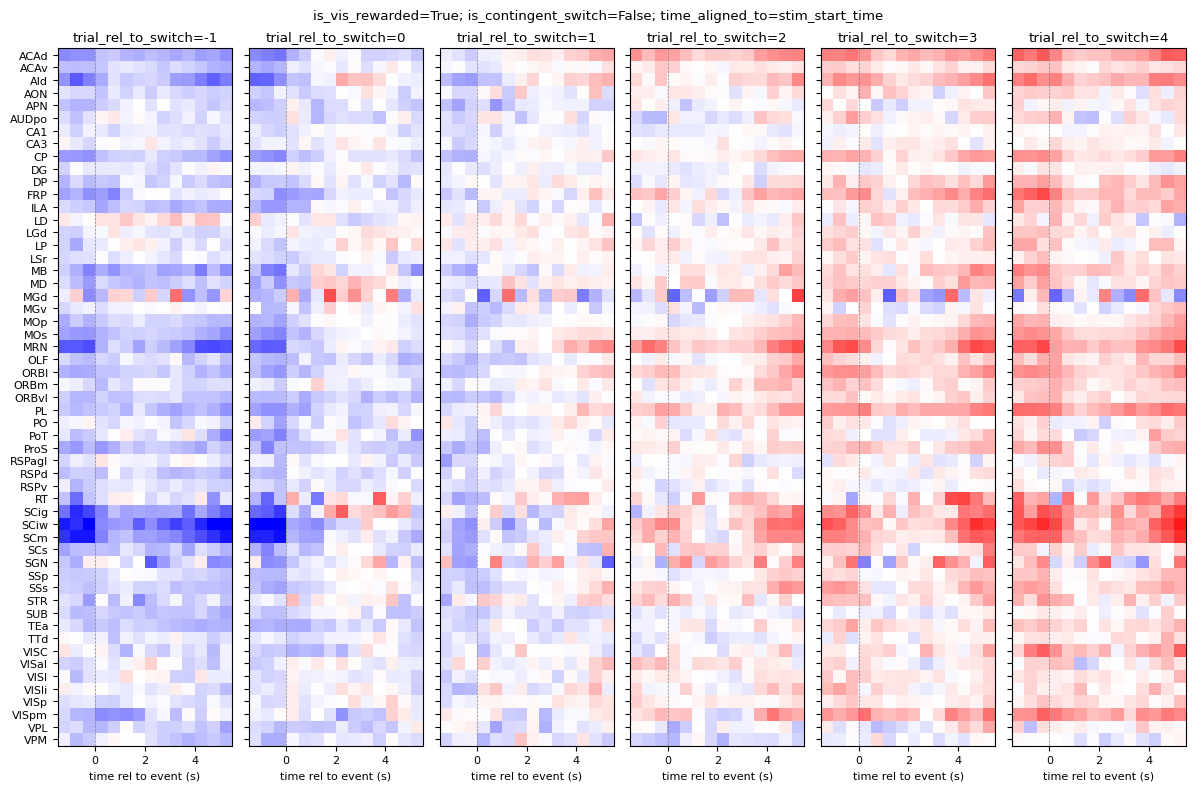

In [67]:
is_vis_rewarded=True
is_contingent_switch=False
min_n_switches=12

structure_result_list=structure_average_predict_proba_df.query('n_switches>=@min_n_switches').sort_values(by='structure')['structure'].unique()

trials_to_plot=[-1,0,1,2,3,4]

fig,ax=plt.subplots(1,len(trials_to_plot),figsize=(12,8),sharex=True,sharey=True)
for xx,sel_trial_rel_to_switch in enumerate(trials_to_plot):
    
    sel_switches=structure_average_predict_proba_df.query(
        'trial_rel_to_switch==@sel_trial_rel_to_switch and \
        is_vis_rewarded==@is_vis_rewarded and \
        is_contingent_switch==@is_contingent_switch')# and \
        # n_switches>=@min_n_switches').sort_values(by='structure')
    
    ax[xx].set_title(f"trial_rel_to_switch={sel_trial_rel_to_switch}")
    if len(sel_switches) == 0:
        continue

    heatmap_array=np.full((len(structure_result_list), len(sel_switches['predict_proba'].iloc[0])), np.nan)

    for ss,structure_str in enumerate(structure_result_list):
        if structure_str in sel_switches['structure'].values:
            heatmap_array[ss,:]=sel_switches.query('structure==@structure_str')['predict_proba'].values[0]
        else:
            heatmap_array[ss,:]=np.nan
            
    im=ax[xx].imshow(heatmap_array, aspect='auto', interpolation='none', cmap='bwr', vmin=0.2, vmax=0.8, extent=[-1.5, 5.5, heatmap_array.shape[0]-0.5,-0.5])
    ax[xx].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    ax[xx].set_xlabel('time rel to event (s)')
    ax[xx].set_yticks(np.arange(len(structure_result_list)))
    ax[xx].set_yticklabels(structure_result_list, ha='right')

fig.suptitle(f"is_vis_rewarded={is_vis_rewarded}; is_contingent_switch={is_contingent_switch}; time_aligned_to={sel_time_aligned_to}")
fig.tight_layout()

In [ ]:
sel_switches

In [ ]:
# distribution of switch-provoked changes in predict_proba

sel_structure='PL'
sel_trial_rel_to_switch=0
# sel_is_vis_context=True
# sel_is_contingent_switch=False
# min_n_switches=12
min_dprime=0.5

xbins=np.arange(-1.0,1.0+.1,0.005)
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.axvline(0, color='k', linestyle='--', linewidth=0.5)

context_label=['V->A','A->V']
contingent_label=['noncontingent','contingent']

for sel_is_vis_context in [False,True]:
    for sel_is_contingent_switch in [False,True]:
        
        label_str= f"{context_label[int(sel_is_vis_context)]} {contingent_label[int(sel_is_contingent_switch)]}"

        switches=context_switch_table_df.query(
            'structure==@sel_structure and is_vis_context==@sel_is_vis_context and trial_rel_to_switch==@sel_trial_rel_to_switch and \
            is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')

        ax.hist(switches['delta_predict_proba_2_bins'],bins=xbins,label=label_str,cumulative=True,histtype='step',density=True)

ax.legend()
ax.set_xlabel('change in predict_proba (2 bins)')
ax.set_ylabel('cumulative density')
ax.set_title(f"{sel_structure}; trial_rel_to_switch={sel_trial_rel_to_switch}; min_dprime={min_dprime}")


In [ ]:
switches['delta_predict_proba_2_bins'].mean()

In [71]:
#get average and sem delta predict proba per structure, make new dataframe

sel_trial_rel_to_switch=0
min_dprime=0.5
context_labels=['aud','vis']
contingent_labels=['non_contingent','contingent']

delta_predict_proba_by_structure={
    'structure':[],

    'delta_2_vis_contingent_mean':[],
    'delta_3_vis_contingent_mean':[],
    'delta_2_vis_contingent_sem':[],
    'delta_3_vis_contingent_sem':[],
    'n_switches_vis_contingent':[],

    'delta_2_vis_non_contingent_mean':[],
    'delta_3_vis_non_contingent_mean':[],
    'delta_2_vis_non_contingent_sem':[],
    'delta_3_vis_non_contingent_sem':[],
    'n_switches_vis_non_contingent':[],

    'delta_2_aud_contingent_mean':[],
    'delta_3_aud_contingent_mean':[],
    'delta_2_aud_contingent_sem':[],
    'delta_3_aud_contingent_sem':[],
    'n_switches_aud_contingent':[],

    'delta_2_aud_non_contingent_mean':[],
    'delta_3_aud_non_contingent_mean':[],
    'delta_2_aud_non_contingent_sem':[],
    'delta_3_aud_non_contingent_sem':[],
    'n_switches_aud_non_contingent':[],
}

for sel_structure in context_switch_table_df['structure'].unique():
    delta_predict_proba_by_structure['structure'].append(sel_structure)
    for sel_is_vis_rewarded in [False,True]:
        for sel_is_contingent_switch in [False,True]:
            
            switches=context_switch_table_df.query(
                'structure==@sel_structure and is_vis_rewarded==@sel_is_vis_rewarded and trial_rel_to_switch==@sel_trial_rel_to_switch and \
                is_contingent_switch==@sel_is_contingent_switch and dprime_before_switch>=@min_dprime and dprime_after_switch>=@min_dprime')
            
            delta_predict_proba_by_structure[f'delta_2_{context_labels[sel_is_vis_rewarded]}_{contingent_labels[sel_is_contingent_switch]}_mean'].append(switches['delta_predict_proba_2_bins'].median())
            delta_predict_proba_by_structure[f'delta_3_{context_labels[sel_is_vis_rewarded]}_{contingent_labels[sel_is_contingent_switch]}_mean'].append(switches['delta_predict_proba_3_bins'].median())
            delta_predict_proba_by_structure[f'delta_2_{context_labels[sel_is_vis_rewarded]}_{contingent_labels[sel_is_contingent_switch]}_sem'].append(stats.sem(switches['delta_predict_proba_2_bins']))
            delta_predict_proba_by_structure[f'delta_3_{context_labels[sel_is_vis_rewarded]}_{contingent_labels[sel_is_contingent_switch]}_sem'].append(stats.sem(switches['delta_predict_proba_3_bins']))
            delta_predict_proba_by_structure[f'n_switches_{context_labels[sel_is_vis_rewarded]}_{contingent_labels[sel_is_contingent_switch]}'].append(len(switches))

delta_predict_proba_by_structure_df=pd.DataFrame(delta_predict_proba_by_structure)
delta_predict_proba_by_structure_df

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_14528\1309005463.py:47: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  delta_predict_proba_by_structure[f'delta_2_{context_labels[sel_is_vis_rewarded]}_{contingent_labels[sel_is_contingent_switch]}_sem'].append(stats.sem(switches['delta_predict_proba_2_bins']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_14528\1309005463.py:48: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  delta_predict_proba_by_structure[f'delta_3_{context_labels[sel_is_vis_rewarded]}_{contingent_labels[sel_is_contingent_switch]}_sem'].append(stats.sem(switches['delta_predict_proba_3_bins']))
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_14528\1309005463.py:47: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. Se

,structure,delta_2_vis_contingent_mean,delta_3_vis_contingent_mean,delta_2_vis_contingent_sem,delta_3_vis_contingent_sem,n_switches_vis_contingent,delta_2_vis_non_contingent_mean,delta_3_vis_non_contingent_mean,delta_2_vis_non_contingent_sem,delta_3_vis_non_contingent_sem,...,delta_2_aud_contingent_mean,delta_3_aud_contingent_mean,delta_2_aud_contingent_sem,delta_3_aud_contingent_sem,n_switches_aud_contingent,delta_2_aud_non_contingent_mean,delta_3_aud_non_contingent_mean,delta_2_aud_non_contingent_sem,delta_3_aud_non_contingent_sem,n_switches_aud_non_contingent
0,AUDp,0.103762,0.093868,0.067191,0.061093,6,0.091243,0.061904,0.027409,0.027282,...,-0.017336,-0.052317,0.031369,0.027531,7,-0.098031,-0.061558,0.054188,0.067915,7
1,AUDpo,0.068506,0.044080,0.062347,0.052556,6,0.011721,0.027649,0.049146,0.035882,...,0.037887,0.017893,0.038946,0.017438,6,-0.039866,-0.043411,0.037711,0.032401,12
2,CA1,-0.016317,0.005208,0.015443,0.014670,68,-0.014015,0.001552,0.014988,0.012848,...,-0.041381,-0.039299,0.018703,0.016059,70,-0.009277,-0.013795,0.014074,0.013238,71
3,CP,0.069087,0.066398,0.020918,0.019922,73,0.068591,0.087946,0.020105,0.017029,...,-0.088102,-0.085028,0.021560,0.020576,82,-0.208362,-0.191057,0.021637,0.020974,91
4,DG,-0.048101,-0.015403,0.019537,0.017245,49,-0.006241,-0.020959,0.019867,0.015821,...,0.004927,-0.016493,0.019650,0.016289,48,-0.017751,-0.037366,0.020829,0.018062,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,NB,NaN,NaN,NaN,NaN,0,-0.020163,-0.060168,NaN,NaN,...,-0.204537,-0.169153,NaN,NaN,1,0.161418,0.061133,NaN,NaN,1
144,VPMpc,-0.053013,0.006769,0.061028,0.042345,2,0.117079,0.005358,NaN,NaN,...,-0.093414,-0.108403,NaN,NaN,1,-0.193029,-0.083513,0.016546,0.117080,2
145,LA,NaN,NaN,NaN,NaN,0,-0.025574,-0.041289,0.030182,0.045261,...,0.007434,-0.022098,NaN,NaN,1,-0.172285,-0.204566,NaN,NaN,1
146,SEZ,-0.050441,0.058268,NaN,NaN,1,NaN,NaN,NaN,NaN,...,-0.054776,-0.000169,NaN,NaN,1,0.108616,0.100841,NaN,NaN,1


In [ ]:
# label_str

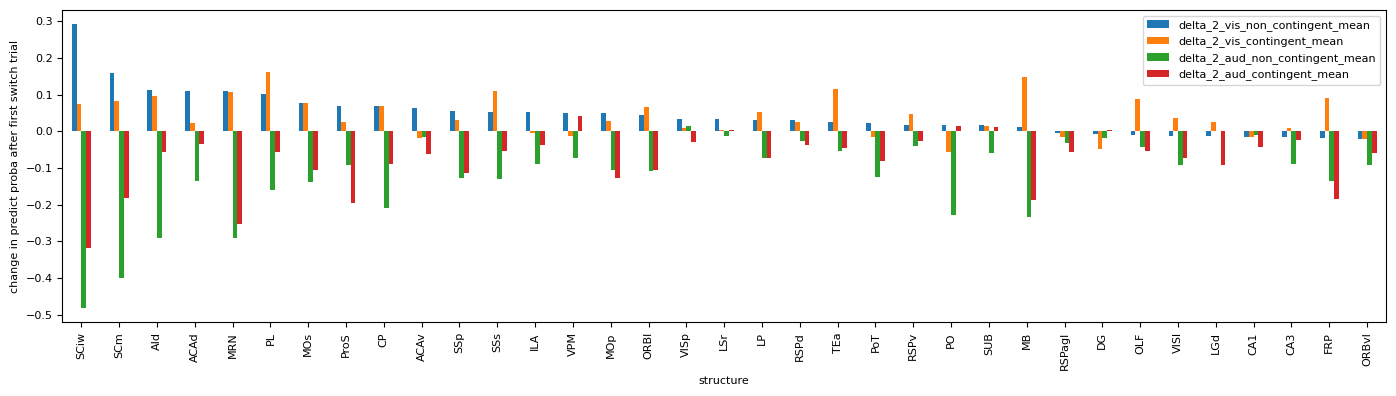

In [72]:
set_min_n_switches=10
sorted_table=delta_predict_proba_by_structure_df.query('n_switches_vis_contingent>=@set_min_n_switches and n_switches_vis_non_contingent>=@set_min_n_switches and \
                                                       n_switches_aud_contingent>=@set_min_n_switches and n_switches_aud_non_contingent>=@set_min_n_switches'
                                                       ).sort_values(by='delta_2_vis_non_contingent_mean', ascending=False)

fig,ax=plt.subplots(1,1,figsize=(14,4))
sorted_table.plot.bar(x='structure', y=['delta_2_vis_non_contingent_mean','delta_2_vis_contingent_mean','delta_2_aud_non_contingent_mean','delta_2_aud_contingent_mean'], ax=ax, legend=True)

ax.set_ylabel('change in predict proba after first switch trial')
fig.tight_layout()

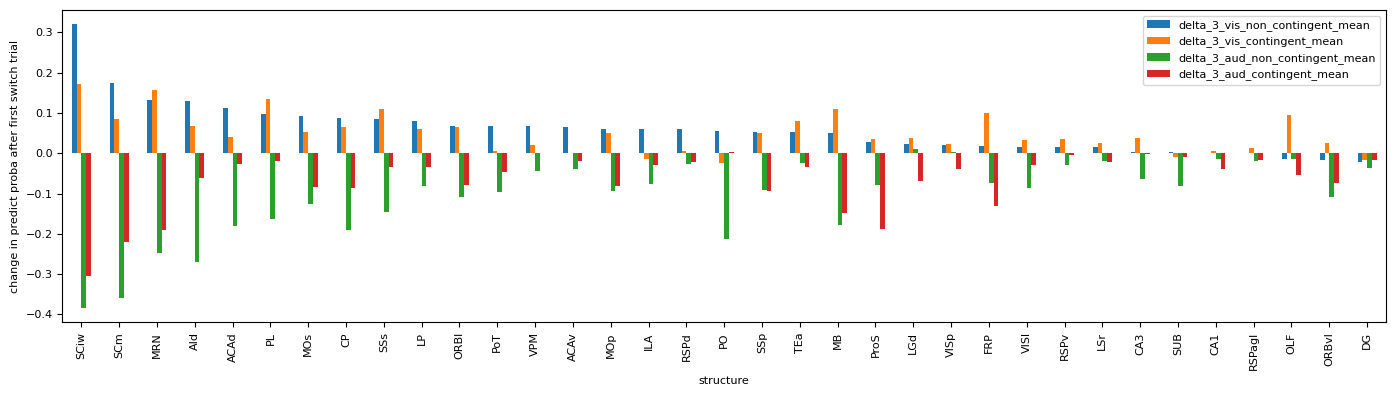

In [73]:
set_min_n_switches=10
sorted_table=delta_predict_proba_by_structure_df.query('n_switches_vis_contingent>=@set_min_n_switches and n_switches_vis_non_contingent>=@set_min_n_switches and \
                                                       n_switches_aud_contingent>=@set_min_n_switches and n_switches_aud_non_contingent>=@set_min_n_switches'
                                                       ).sort_values(by='delta_3_vis_non_contingent_mean', ascending=False)

fig,ax=plt.subplots(1,1,figsize=(14,4))
sorted_table.plot.bar(x='structure', y=['delta_3_vis_non_contingent_mean','delta_3_vis_contingent_mean','delta_3_aud_non_contingent_mean','delta_3_aud_contingent_mean'], ax=ax, legend=True)

ax.set_ylabel('change in predict proba after first switch trial')
fig.tight_layout()

In [ ]:
### TODO: same as above except filter for simultaneously recorded stuctures - maybe ACAd and MOs for example

In [74]:
#get predict_proba for different trial types, make new table

# sel_session="664851_2023-11-13"
# sel_structure="SCm"
sel_unit_subsample_size=20
sel_time_aligned_to='stim_start_time'

# get_trials_rel_to_switch=[-3,-2,-1,0,1,2,3,4]
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect().to_pandas()

trial_type_table={
    'session_id':[],
    'structure':[],
    'predict_proba':[],
    'bin_centers':[],
    'unit_subsample_size':[],
    'time_aligned_to':[],
    'trial_index':[],
    'is_response':[],
    'is_vis_rewarded':[],
    'stim_name':[],
    'n_trials':[],
    'session_dprime':[],
    'n_passing_vis_blocks':[],
    'n_passing_aud_blocks':[],
}

for sel_session in predict_proba_pd['session_id'].unique():
    if sel_session not in dr_session_list:
        print(f"session {sel_session} not in dr_session_list; skipping")
        continue
    
    session_performance=all_performance.query(f'session_id=="{sel_session}"')
    session_dprime=session_performance['cross_modality_dprime'].mean()
    n_passing_vis_blocks=session_performance.query('rewarded_modality=="vis" and cross_modality_dprime>1').shape[0]
    n_passing_aud_blocks=session_performance.query('rewarded_modality=="aud" and cross_modality_dprime>1').shape[0]
    session_trials=all_trials.query(f'session_id=="{sel_session}"')

    for sel_structure in predict_proba_pd.query('session_id==@sel_session')['structure'].unique():

        #get session-structure results
        example_area_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)

        predict_proba_stack=np.vstack(example_area_results['predict_proba'].values).T

        #these are the indices of trials with data (i.e. for response aligned trials)
        trial_index=example_area_results['trial_index'].iloc[0]

        if trial_index.shape[0]!=predict_proba_stack.shape[0]:
            print('warning! trial_index does not match predict_proba_stack, just taking the first X trials')
            trial_index=trial_index[:predict_proba_stack.shape[0]]

        #loop through type of trials?
        for is_vis_rewarded in [True,False]:

            for stim_name in session_trials['stim_name'].unique():

                for is_response in [True,False]:

                    #get the trial indices for this trial type
                    trial_type_indices=session_trials.query(
                        'is_reward_scheduled==False and is_vis_rewarded==@is_vis_rewarded and \
                        stim_name==@stim_name and is_response==@is_response'
                        )['trial_index'].values

                    #get the subset of these trial indices available in the data
                    available_trial_type_indices=np.where(np.isin(trial_index, trial_type_indices))[0]

                    #get the number of trials
                    n_trials=len(available_trial_type_indices)

                    if n_trials == 0:
                        predict_proba_values=np.nan*np.ones(predict_proba_stack.shape[1])
                    else:
                        #get the average preidict_proba for these trials
                        predict_proba_values=np.nanmean(predict_proba_stack[available_trial_type_indices,:], axis=0)

                    trial_type_table['session_id'].append(sel_session)
                    trial_type_table['structure'].append(sel_structure)
                    trial_type_table['predict_proba'].append(predict_proba_values)
                    trial_type_table['bin_centers'].append(example_area_results['bin_center'].values)
                    trial_type_table['unit_subsample_size'].append(sel_unit_subsample_size)
                    trial_type_table['time_aligned_to'].append(sel_time_aligned_to)
                    trial_type_table['trial_index'].append(available_trial_type_indices)
                    trial_type_table['is_response'].append(is_response)
                    trial_type_table['is_vis_rewarded'].append(is_vis_rewarded)
                    trial_type_table['stim_name'].append(stim_name)
                    trial_type_table['n_trials'].append(n_trials)
                    trial_type_table['session_dprime'].append(session_dprime)
                    trial_type_table['n_passing_vis_blocks'].append(n_passing_vis_blocks)
                    trial_type_table['n_passing_aud_blocks'].append(n_passing_aud_blocks)


trial_type_table_df=pd.DataFrame(trial_type_table)



session 620263_2022-07-26 not in dr_session_list; skipping
session 620263_2022-07-27 not in dr_session_list; skipping
session 620264_2022-08-02 not in dr_session_list; skipping
session 628801_2022-09-19 not in dr_session_list; skipping
session 636397_2022-09-26 not in dr_session_list; skipping
session 636397_2022-09-27 not in dr_session_list; skipping
session 644547_2022-12-05 not in dr_session_list; skipping
session 644547_2022-12-06 not in dr_session_list; skipping
session 646318_2023-01-17 not in dr_session_list; skipping
session 646318_2023-01-18 not in dr_session_list; skipping
session 649944_2023-02-27 not in dr_session_list; skipping
session 649944_2023-02-28 not in dr_session_list; skipping
session 662983_2023-05-15 not in dr_session_list; skipping
session 662983_2023-05-16 not in dr_session_list; skipping
session 668759_2023-07-11 not in dr_session_list; skipping
session 668759_2023-07-12 not in dr_session_list; skipping
session 668759_2023-07-13 not in dr_session_list; skippi

In [75]:
trial_type_table_df

,session_id,structure,predict_proba,bin_centers,unit_subsample_size,time_aligned_to,trial_index,is_response,is_vis_rewarded,stim_name,n_trials,session_dprime,n_passing_vis_blocks,n_passing_aud_blocks
0,626791_2022-08-15,AUDp,"[0.6320396812440945, 0.6260392930698276, 0.612...","[-1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, ...",20,stim_start_time,"[11, 18, 20, 24, 26, 27, 29, 36, 43, 44, 57, 5...",True,True,vis1,53,1.705494,3,2
1,626791_2022-08-15,AUDp,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, ...",20,stim_start_time,[],False,True,vis1,0,1.705494,3,2
2,626791_2022-08-15,AUDp,"[0.5280427266886617, 0.5629377527375632, 0.580...","[-1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, ...",20,stim_start_time,"[5, 165, 230, 335, 387, 389]",True,True,sound2,6,1.705494,3,2
3,626791_2022-08-15,AUDp,"[0.6447064086211566, 0.6230801480249498, 0.624...","[-1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, ...",20,stim_start_time,"[10, 14, 16, 19, 31, 32, 40, 41, 47, 55, 61, 6...",False,True,sound2,50,1.705494,3,2
4,626791_2022-08-15,AUDp,"[0.6172561056912514, 0.5825005186068716, 0.570...","[-1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, ...",20,stim_start_time,"[6, 21, 37, 164, 169, 172, 181, 207, 212, 213,...",True,True,sound1,24,1.705494,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40515,761583_2024-12-17,VPM,"[0.48508506896703013, 0.489523418611058, 0.483...","[-1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, ...",20,stim_start_time,"[27, 38, 44, 52, 53, 69, 76, 83, 86, 201, 202,...",False,False,vis1,34,1.663124,2,3
40516,761583_2024-12-17,VPM,"[0.4846100010079759, 0.48480286598489325, 0.46...","[-1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, ...",20,stim_start_time,"[8, 9, 11, 21, 29, 35, 36, 48, 50, 61, 62, 73,...",True,False,sound2,28,1.663124,2,3
40517,761583_2024-12-17,VPM,"[0.511748178422026, 0.5065614303584999, 0.4870...","[-1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, ...",20,stim_start_time,"[10, 39, 54, 63, 72, 79, 84, 191, 193, 221, 23...",False,False,sound2,32,1.663124,2,3
40518,761583_2024-12-17,VPM,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[-1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, ...",20,stim_start_time,[],True,False,catch,0,1.663124,2,3


In [ ]:
#subtract average stimlus/context predict proba from each switch in each session-structure

predict_proba_corrected=[]

for rr, row in structure_average_predict_proba_df.iterrows():
    structure=row['structure']
    temp_is_vis_rewarded=row['is_vis_rewarded']
    if temp_is_vis_rewarded:
        stim='vis1'
    else:
        stim='sound1'

    #get the average for the previous context
    temp_is_vis_rewarded= not temp_is_vis_rewarded

    matched_structure_trial_average=np.nanmean(np.vstack(trial_type_table_df.query('structure==@structure and is_vis_rewarded==@temp_is_vis_rewarded and stim_name==@stim')['predict_proba'].values),axis=0)
    predict_proba_corrected.append(
        row['predict_proba'] - matched_structure_trial_average
    )

structure_average_predict_proba_df['predict_proba_corrected'] = predict_proba_corrected

In [77]:
# trial_type_table_df.query('structure==@structure and is_vis_rewarded==@is_vis_rewarded and stim_name==@stim')['predict_proba'].values
# not row['is_vis_rewarded']
structure_average_predict_proba_df

,structure,predict_proba,trial_rel_to_switch,is_contingent_switch,is_vis_rewarded,n_switches,predict_proba_corrected
0,AUDp,"[0.4097901756933935, 0.44077143018770665, 0.38...",-1,True,True,6,"[-0.009592653586142086, 0.022101694203865097, ..."
1,AUDp,"[0.4634744178277304, 0.40841360065433396, 0.42...",0,True,True,6,"[0.04409158854819484, -0.010256135329507587, 0..."
2,AUDp,"[0.5233922565417534, 0.5176271027404831, 0.588...",1,True,True,6,"[0.10400942726221779, 0.09895736675664152, 0.1..."
3,AUDp,"[0.5846648458371714, 0.5628753640773324, 0.618...",2,True,True,6,"[0.1652820165576358, 0.14420562809349086, 0.19..."
4,AUDp,"[0.5803177974294224, 0.5146617189803785, 0.638...",3,True,True,6,"[0.16093496814988678, 0.09599198299653694, 0.2..."
...,...,...,...,...,...,...,...
3043,VTA,"[0.5457867839305834, 0.5305950957199526, 0.358...",0,False,False,2,"[-0.049143611020529665, -0.08979833795668579, ..."
3044,VTA,"[0.7621448154617843, 0.45419713815328794, 0.69...",1,False,False,2,"[0.16721442051067115, -0.1661962955233504, 0.0..."
3045,VTA,"[0.1822095115031673, 0.4310299505488128, 0.469...",2,False,False,2,"[-0.4127208834479458, -0.18936348312782553, -0..."
3046,VTA,"[0.07837849544320732, 0.2970478111199729, 0.25...",3,False,False,2,"[-0.5165518995079058, -0.32334562255666544, -0..."


In [78]:
structure_average_predict_proba_df.query('structure=="ACAd"')
# trial_type_table_df.query('structure=="ACAd" and is_vis_rewarded==~@is_vis_rewarded and stim_name==@stim')

,structure,predict_proba,trial_rel_to_switch,is_contingent_switch,is_vis_rewarded,n_switches,predict_proba_corrected
1056,ACAd,"[0.3966113131041845, 0.42630416772336477, 0.41...",-1,True,True,35,"[0.020480233384956747, 0.05724571313126131, 0...."
1057,ACAd,"[0.4645490828433935, 0.4537620991259609, 0.475...",0,True,True,35,"[0.08841800312416576, 0.08470364453385743, 0.1..."
1058,ACAd,"[0.5661076030729084, 0.528757438150376, 0.5401...",1,True,True,35,"[0.18997652335368065, 0.15969898355827256, 0.1..."
1059,ACAd,"[0.6084342906706517, 0.6185826314852461, 0.625...",2,True,True,35,"[0.23230321095142392, 0.2495241768931426, 0.25..."
1060,ACAd,"[0.6098666651284718, 0.6054970101961428, 0.635...",3,True,True,35,"[0.233735585409244, 0.2364385556040393, 0.2650..."
1061,ACAd,"[0.6386368441955222, 0.659742798968796, 0.6659...",4,True,True,35,"[0.2625057644762945, 0.2906843443766925, 0.295..."
1062,ACAd,"[0.3638279778894909, 0.36895133552232234, 0.37...",-1,False,True,46,"[-0.012303101829736873, -0.0001071190697811141..."
1063,ACAd,"[0.3638994924561973, 0.348272001029706, 0.3359...",0,False,True,46,"[-0.012231587263030474, -0.020786453562397444,..."
1064,ACAd,"[0.4804128633665746, 0.4665270478937183, 0.440...",1,False,True,46,"[0.10428178364734686, 0.09746859330161484, 0.0..."
1065,ACAd,"[0.6269916297230631, 0.5779489101198955, 0.619...",2,False,True,46,"[0.25086055000383534, 0.208890455527792, 0.249..."


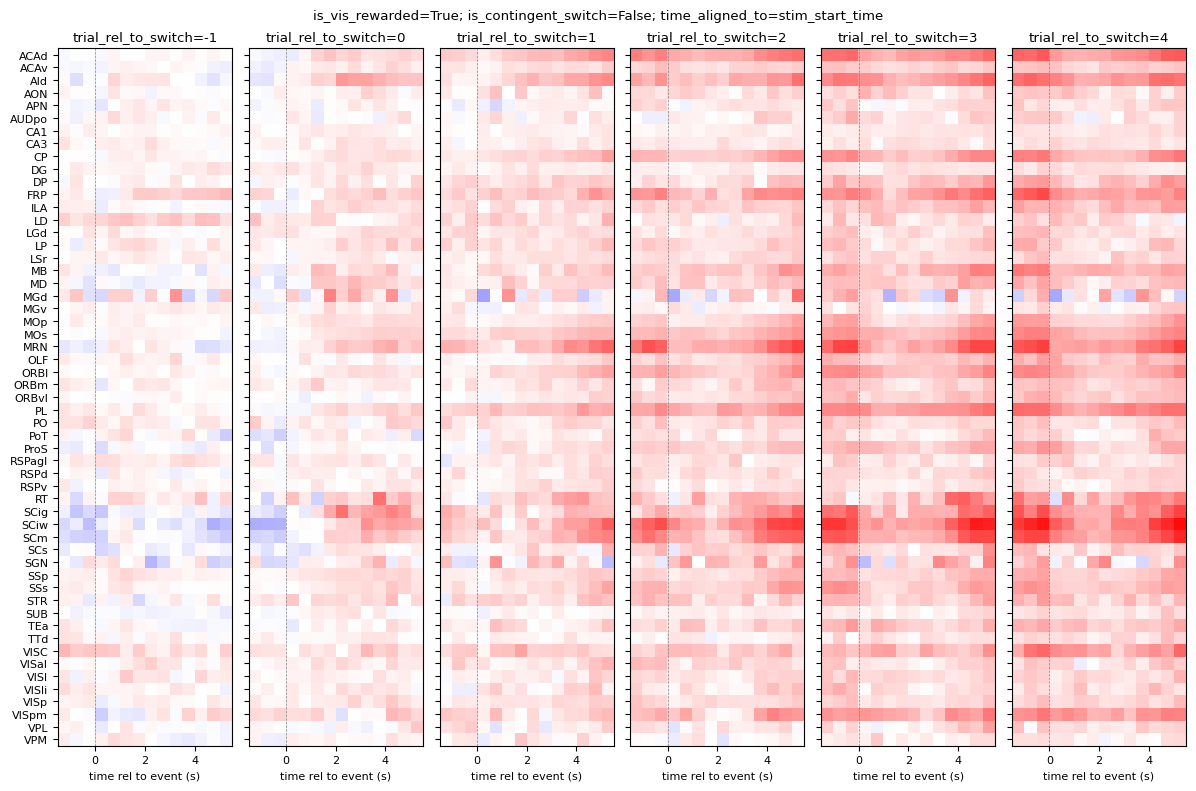

In [84]:
is_vis_rewarded=True
is_contingent_switch=False
min_n_switches=12

structure_result_list=structure_average_predict_proba_df.query('n_switches>=@min_n_switches').sort_values(by='structure')['structure'].unique()

fig,ax=plt.subplots(1,6,figsize=(12,8),sharex=True,sharey=True)
for xx,sel_trial_rel_to_switch in enumerate([-1,0,1,2,3,4]):
    
    sel_switches=structure_average_predict_proba_df.query(
        'trial_rel_to_switch==@sel_trial_rel_to_switch and \
        is_vis_rewarded==@is_vis_rewarded and \
        is_contingent_switch==@is_contingent_switch')# and \
        # n_switches>=@min_n_switches').sort_values(by='structure')
    
    ax[xx].set_title(f"trial_rel_to_switch={sel_trial_rel_to_switch}")
    if len(sel_switches) == 0:
        continue

    heatmap_array=np.full((len(structure_result_list), len(sel_switches['predict_proba_corrected'].iloc[0])), np.nan)

    for ss,structure_str in enumerate(structure_result_list):
        if structure_str in sel_switches['structure'].values:
            heatmap_array[ss,:]=sel_switches.query('structure==@structure_str')['predict_proba_corrected'].values[0]
        else:
            heatmap_array[ss,:]=np.nan
            
    im=ax[xx].imshow(heatmap_array, aspect='auto', interpolation='none', cmap='bwr', vmin=-0.5, vmax=0.5, extent=[-1.5, 5.5, heatmap_array.shape[0]-0.5,-0.5])
    ax[xx].axvline(x=0, color='grey', linestyle='--', linewidth=0.5)
    ax[xx].set_xlabel('time rel to event (s)')
    ax[xx].set_yticks(np.arange(len(structure_result_list)))
    ax[xx].set_yticklabels(structure_result_list, ha='right')

fig.suptitle(f"is_vis_rewarded={is_vis_rewarded}; is_contingent_switch={is_contingent_switch}; time_aligned_to={sel_time_aligned_to}")
fig.tight_layout()

In [ ]:
# available_trial_type_indices
trial_index.shape
# predict_proba_stack.shape
# np.isin(trial_type_indices, trial_index)
# trial_index
# example_area_results['stim_name'].iloc[0][available_trial_type_indices]

In [ ]:
# trial_type_table_df

In [ ]:
# sel_structure='ACAd'

min_n_trials=3

min_n_good_blocks=2

savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-05-19-decoder_timepoints_0.5_bins\trial_types-response_time"

for sel_structure in trial_type_table_df['structure'].unique():

    fig,ax=plt.subplots(2,5,figsize=(14,6),sharex=True,sharey=True)

    for xx,sel_is_vis_context in enumerate([True,False]):

        for st, stim_name in enumerate(['vis1','vis2','sound1','sound2','catch']):

            for is_response in [True,False]:

                #get the trial type data
                trial_type_data=trial_type_table_df.query(
                    'structure==@sel_structure and is_vis_context==@sel_is_vis_context and \
                    stim_name==@stim_name and is_response==@is_response and n_trials>=@min_n_trials and \
                    n_passing_vis_blocks>=@min_n_good_blocks and n_passing_aud_blocks>=@min_n_good_blocks')

                if is_response:
                    plot_color='green'
                else:
                    plot_color='black'

                if len(trial_type_data) > 0:
                    n_trials=trial_type_data['predict_proba'].values.shape[0]
                    ax[xx,st].axvline(0,linestyle='--',color='k',linewidth=0.5)
                    ax[xx,st].axhline(0.5,linestyle='--',color='k',linewidth=0.5)
                    ax[xx,st].plot(trial_type_data['bin_centers'].iloc[0], 
                            np.nanmean(np.vstack(trial_type_data['predict_proba'].values),axis=0), 
                            label=f'is_response={str(is_response)} ({str(n_trials)})', color=plot_color, marker='.')
                    ax[xx,st].fill_between(
                        trial_type_data['bin_centers'].iloc[0], 
                        np.nanmean(np.vstack(trial_type_data['predict_proba'].values),axis=0)
                        -stats.sem(np.vstack(trial_type_data['predict_proba'].values),axis=0), 
                        np.nanmean(np.vstack(trial_type_data['predict_proba'].values),axis=0)
                        +stats.sem(np.vstack(trial_type_data['predict_proba'].values),axis=0), 
                        color=plot_color, alpha=0.2)

            # ax.set_ylim(0.2,0.8)
            ax[xx,st].set_xlabel('time rel to event (s)')
            if st==0:
                ax[xx,st].set_ylabel('predict_proba')
            ax[xx,st].legend()
            if sel_is_vis_context:
                ax[xx,st].set_title(f"{stim_name}; vis context")
            else:
                ax[xx,st].set_title(f"{stim_name}; aud context")

    fig.suptitle(f'{sel_structure}; aligned to {sel_time_aligned_to}')
    fig.tight_layout()

    sel_structure=sel_structure.replace('/','-')
    
    fig.savefig(os.path.join(savepath,f'{sel_structure}_{sel_time_aligned_to}'))
    plt.close(fig)


In [ ]:
f'{sel_structure}_{sel_time_aligned_to}'

In [ ]:
# predict_proba_pd

In [ ]:
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect().to_pandas()
all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect().to_pandas()

In [ ]:
# p(resp) versus p(vis context)
normalize_by_block=False
sel_project='DynamicRouting'
sel_unit_subsample_size=20
sel_bin_center=-0.25
unique_sessions=session_table.to_pandas().query('project==@sel_project')['session_id'].unique()

all_structures=[]

# #for each unique session
for ss,session_id in enumerate(unique_sessions):

    session_confidence=predict_proba_pd.query('session_id==@session_id and unit_subsample_size==@sel_unit_subsample_size and bin_center==@sel_bin_center')
    session_structures=session_confidence['structure'].unique()

    if len(session_confidence)==0:
        print(f'session_id {session_id} has no predict_proba data, skipping...')
        continue

    #load trials table & performance table
    trials=all_trials.query('session_id==@session_id')
    performance=all_performance.query('session_id==@session_id')

    if len(session_confidence['predict_proba'].iloc[0])!=len(trials):
        print(f'session_id {session_id} has different number of trials than predict_proba table, skipping...')
        continue

    #### How to normalize response rate by block/session?? ###

    # block_norm_response_rate=np.full(len(trials), np.nan)
    # add blockwise and session-wide performance to trials table
    for block_index in trials['block_index'].unique():
        block_performance=performance.query('block_index==@block_index')
        trials.loc[trials['block_index']==block_index,'block_dprime']=block_performance['cross_modality_dprime'].values[0]

        # block_trial_idx=trials.query('block_index==@block_index')['trial_index'].values
        # block_trials=trials.query('block_index==@block_index')
        # block_response_rate=block_trials['is_response'].mean()
        # session_response_rate=trials

    trials['session_dprime']=performance['cross_modality_dprime'].mean()
    trials['session_id']=session_id

    for structure in session_structures:
        # ss=session_structures[0]
        structure_confidence=session_confidence.query('structure==@structure')
        if len(structure_confidence)==0:
            continue
        structure_predict_proba=structure_confidence['predict_proba'].values[0]

        if normalize_by_block:
            block_normalized_predict_proba=np.full(len(trials), np.nan)
            for block_index in trials['block_index'].unique():
                block_trial_idx=trials.query('block_index==@block_index')['trial_index'].values
                block_normalized_predict_proba[block_trial_idx]=structure_predict_proba[block_trial_idx]-np.nanmean(structure_predict_proba[block_trial_idx])

            # trials[structure+'_predict_proba']=structure_predict_proba
            trials[structure+'_predict_proba']=block_normalized_predict_proba
        else:
            trials[structure+'_predict_proba']=structure_predict_proba

        if structure not in all_structures:
            all_structures.append(structure)

    if ss==0:
        all_trials_with_decoder_confidence=trials
    else:
        all_trials_with_decoder_confidence=pd.concat([all_trials_with_decoder_confidence,trials],axis=0,ignore_index=True)
        
# all_trials_with_decoder_confidence.to_parquet(
#     r'\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\new_decoder_run_2025-04-04\all_trials_with_predict_proba.parquet')


In [ ]:
# normalize_by_block=True
# all_trials_with_decoder_confidence

In [ ]:
unique_areas=predict_proba_pd['structure'].unique()
unique_areas

In [ ]:
figsavepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-07-02-predict_proba_vs_response_rate_normalized\raw_predict_proba"
# sel_structure='SCm'

unique_areas=predict_proba_pd['structure'].unique()

targets=['aud','vis']
contexts=['aud','vis']
# dprime_threshold=1.0

if normalize_by_block:
    conf_bins=np.array([-1.0,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,1.0])
else:
    conf_bins=np.array([0,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,1.0])

conf_bin_midpoints=conf_bins[:-1]+np.diff(conf_bins)/2

for sel_structure in unique_areas:

    fig,ax=plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)

    for sel_context in contexts:

        if sel_context=='aud':
            axind=0
        elif sel_context=='vis':
            axind=1

        for sel_target in targets:

            structure_predict_proba=all_trials_with_decoder_confidence.query('is_'+sel_context+'_rewarded and is_'+sel_target+'_target')[[sel_structure+'_predict_proba','is_response']]
            structure_predict_proba_nontarget=all_trials_with_decoder_confidence.query('is_'+sel_context+'_rewarded and is_'+sel_target+'_nontarget')[[sel_structure+'_predict_proba','is_response']]
            # structure_predict_proba=all_trials_with_decoder_confidence.query('is_'+sel_context+'_rewarded and is_'+sel_target+'_target and block_dprime>=@dprime_threshold')[[sel_structure+'_predict_proba','is_response']]

            predict_proba_bins=pd.cut(structure_predict_proba[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)
            structure_predict_proba['predict_proba_bins']=predict_proba_bins

            structure_predict_proba_nontarget['predict_proba_bins']=pd.cut(structure_predict_proba_nontarget[sel_structure+'_predict_proba'],bins=conf_bins,labels=False)

            #mean values for targets
            mean_bin_values=[]
            bin_sems=[]
            #mean values for non-targets
            mean_bin_values_nontargets=[]
            bin_sems_nontargets=[]

            for bb in range(len(conf_bins[:-1])):
                bin_data=structure_predict_proba.query('predict_proba_bins==@bb')
                mean_bin_values.append(np.nanmean(bin_data['is_response']))
                bin_sems.append(stats.sem(bin_data['is_response'],nan_policy='omit'))
                #mean values for non-targets
                bin_data_nontargets=structure_predict_proba_nontarget.query('predict_proba_bins==@bb')
                mean_bin_values_nontargets.append(np.nanmean(bin_data_nontargets['is_response']))
                bin_sems_nontargets.append(stats.sem(bin_data_nontargets['is_response'],nan_policy='omit'))


            # ax.errorbar(conf_bin_midpoints,mean_bin_values,yerr=bin_sems,marker='.')
            ax[0,axind].plot(conf_bin_midpoints,mean_bin_values,marker='.',label=sel_target)
            ax[0,axind].fill_between(conf_bin_midpoints,np.array(mean_bin_values)-np.array(bin_sems),np.array(mean_bin_values)+np.array(bin_sems),alpha=0.2)
            ax[0,axind].set_xlabel('aud <- normalized predict probability -> vis')
            ax[0,axind].set_ylabel('response probability')
            ax[0,axind].set_title(sel_structure+' '+sel_context+' context')

            ax[1,axind].plot(conf_bin_midpoints,mean_bin_values_nontargets,marker='.',label=sel_target)
            ax[1,axind].fill_between(conf_bin_midpoints,np.array(mean_bin_values_nontargets)-np.array(bin_sems_nontargets),np.array(mean_bin_values_nontargets)+np.array(bin_sems_nontargets),alpha=0.2)
            ax[1,axind].set_xlabel('aud <- normalized predict probability -> vis')
            ax[1,axind].set_ylabel('response probability')
            ax[1,axind].set_title(sel_structure+' '+sel_context+' context (non-targets)')
        
        if normalize_by_block:
            ax[0,axind].axvline(0,color='k',linewidth=0.5,linestyle='--')
            ax[1,axind].axvline(0,color='k',linewidth=0.5,linestyle='--')
        else:
            ax[0,axind].axvline(0.5,color='k',linewidth=0.5,linestyle='--')
            ax[1,axind].axvline(0.5,color='k',linewidth=0.5,linestyle='--')
            
        ax[0,axind].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax[0,axind].legend(title='target')

        ax[1,axind].axhline(0.5,color='k',linewidth=0.5,linestyle='--')
        ax[1,axind].legend(title='nontarget')

    fig.suptitle(f"{sel_structure} predict proba vs response rate; bin center={sel_bin_center}; unit subsample size={sel_unit_subsample_size}; normalize_by_block={normalize_by_block}")
    fig.tight_layout()
    fig.savefig(os.path.join(figsavepath,f"{sel_structure.replace('/','-')}_predict_proba_vs_response_rate_normalized.png"), dpi=300)
    plt.close(fig)



In [ ]:
performance.columns

In [ ]:
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect().to_pandas()

In [ ]:
all_trials.columns

In [ ]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    # pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [ ]:
# dr_session_list

In [ ]:
# all_trials['stim_start_time'].iloc[1:].values-all_trials['stim_stop_time'].iloc[:-1].values

all_itis=[]

for session_id in all_trials['session_id'].unique():
    if session_id not in dr_session_list:
        continue
    session_itis=all_trials.query('session_id==@session_id')['stim_start_time'].values[1:]-all_trials.query('session_id==@session_id')['stim_start_time'].values[:-1]
    all_itis.append(session_itis)

all_itis_array=np.hstack(all_itis)

In [ ]:
xbins=np.arange(0, 16, 0.1)

fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(all_itis_array, bins=xbins, color='grey')

ax.set_title('time between stimulus start and next stimulus start')

ax.set_xlabel('ITI (s)')
ax.set_ylabel('count')

fig.tight_layout()

In [ ]:
np.percentile(all_itis_array, 80)

In [ ]:
select_ranges=[
    [5.5,6],
    [6,6.5],
    [6.5,7],
    [7,7.5],
    [7.5,8],
    [8,8.5],
    [8.5,9],
    [9,10],
    [10,15]
]

xbins=np.arange(0, 15, 0.1)

fig,ax=plt.subplots(1,1,figsize=(4,3))

for rr in select_ranges:
    # print(f"range {rr[0]}-{rr[1]}")
    # print(np.mean((all_itis_array>rr[0]) & (all_itis_array<rr[1]))*100)

    range_itis=all_itis_array[(all_itis_array>=rr[0])&(all_itis_array<rr[1])]

    percent_of_trials=len(range_itis)/len(all_itis_array)*100

    ax.hist(range_itis, bins=xbins, label=f"{rr[0]}-{rr[1]}: {percent_of_trials:.1f}%")

ax.legend()

ax.set_xlabel('ITI (s)')
ax.set_ylabel('count')

fig.tight_layout()

In [ ]:
select_ranges=[
    # [5.5,6],
    # [6,6.5],
    # [6.5,7],
    # [7,7.5],
    # [7.5,8],
    # [8,8.5],
    # [8.5,9],
    # [9,10],
    # [10,15]
    [5.5,6.5],
    [6.5,7.5],
    [7.5,8.5],
    [8.5,9.5],
    [9.5,16]
]

xbins=np.arange(0, 15, 0.1)

fig,ax=plt.subplots(1,1,figsize=(4,3))

for rr in select_ranges:
    # print(f"range {rr[0]}-{rr[1]}")
    # print(np.mean((all_itis_array>rr[0]) & (all_itis_array<rr[1]))*100)

    range_itis=all_itis_array[(all_itis_array>=rr[0])]

    percent_of_trials=len(range_itis)/len(all_itis_array)*100

    ax.hist(range_itis, bins=xbins, label=f">={rr[0]}: {percent_of_trials:.1f}%",alpha=0.5)

ax.legend()

ax.set_xlabel('ITI (s)')
ax.set_ylabel('count')

fig.tight_layout()

In [ ]:
len(np.arange(-1.5,5.5,0.5))

In [ ]:
all_reaction_times=all_trials.query('is_response and session_id in @dr_session_list')['response_time'].values-all_trials.query('is_response and session_id in @dr_session_list')['stim_start_time'].values
all_reaction_times
fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(all_reaction_times, bins=np.arange(0, 1.01, 0.01), color='grey')
ax.axvline(x=np.nanmedian(all_reaction_times), color='red', linestyle='--', linewidth=0.5, label=f"median={np.nanmedian(all_reaction_times):.2f}")

ax.set_xlabel('reaction time (s)')
ax.set_ylabel('count')
ax.legend()
fig.tight_layout()

In [ ]:
#differentiate hits and false alarms
all_reaction_times_hits=(
    all_trials.query('is_hit and session_id in @dr_session_list')['response_time'].values-
    all_trials.query('is_hit and session_id in @dr_session_list')['stim_start_time'].values
)
all_reaction_times_fa=(
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list')['response_time'].values-
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list')['stim_start_time'].values
)

fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(all_reaction_times_hits, bins=np.arange(0, 1.01, 0.01), color='green', alpha=0.5, label='hits', cumulative=True, density=True, histtype="step",)
ax.hist(all_reaction_times_fa, bins=np.arange(0, 1.01, 0.01), color='red', alpha=0.5, label='false alarms', cumulative=True, density=True, histtype="step",)


In [ ]:
#differentiate hits and false alarms
all_reaction_times_hits_vis=(
    all_trials.query('is_hit and session_id in @dr_session_list and is_vis_target')['response_time'].values-
    all_trials.query('is_hit and session_id in @dr_session_list and is_vis_target')['stim_start_time'].values
)
all_reaction_times_fa_vis=(
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list and is_vis_target')['response_time'].values-
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list and is_vis_target')['stim_start_time'].values
)
all_reaction_times_hits_aud=(
    all_trials.query('is_hit and session_id in @dr_session_list and is_aud_target')['response_time'].values-
    all_trials.query('is_hit and session_id in @dr_session_list and is_aud_target')['stim_start_time'].values
)
all_reaction_times_fa_aud=(
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list and is_aud_target')['response_time'].values-
    all_trials.query('is_false_alarm and is_target and session_id in @dr_session_list and is_aud_target')['stim_start_time'].values
)


fig,ax=plt.subplots(1,1,figsize=(4,3))
ax.hist(all_reaction_times_hits_vis, bins=np.arange(0, 1.01, 0.01), color='tab:green', alpha=0.5, 
        label='vis hits', cumulative=True, density=True, histtype="step",linewidth=1.5)
ax.hist(all_reaction_times_fa_vis, bins=np.arange(0, 1.01, 0.01), color='tab:red', alpha=0.5, 
        label='vis fas', cumulative=True, density=True, histtype="step",linewidth=1.5)
ax.hist(all_reaction_times_hits_aud, bins=np.arange(0, 1.01, 0.01), color='tab:green', alpha=0.5, 
        label='aud hits', cumulative=True, density=True, histtype="step",linewidth=1.5,linestyle='--')
ax.hist(all_reaction_times_fa_aud, bins=np.arange(0, 1.01, 0.01), color='tab:red', alpha=0.5, 
        label='aud fas', cumulative=True, density=True, histtype="step",linewidth=1.5,linestyle='--')

ax.legend()
ax.set_xlabel('reaction time (s)')
ax.set_ylabel('cumulative density')
fig.tight_layout()
